# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [1]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [2]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [3]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,claude-3-5-sonnet-20241022-t0.0--claude-3-5-so...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
102139,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_5,Played,1.0
102140,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_6,Played,0.0
102141,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_7,Played,1.0
102142,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [4]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-Q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-32B',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5C-7B',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0': 'Llama-3.1-405B',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0': 'GPT-4o',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0': 'Claude-3.5',
    'qwen-max-t0.0--qwen-max-t0.0': 'Qwen-max',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0': 'Gemini-2.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0': 'DeepSeek-V3',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0': 'o3-mini'
}

top_models = [
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0'
    ]

final_models = [
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'qwen-max-t0.0--qwen-max-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0'
]

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [5]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
102139,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_5,Played,1.0
102140,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_6,Played,0.0
102141,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,Played,1.0
102142,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,Played,0.0


## Overall benchmark scores

In [6]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [7]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B,39.47,95.31,41.41,49.45,95.31,41.41
Llama-3-8B,2.44,39.06,6.25,24.30,39.06,6.25
Llama-3.1-70B,41.36,94.53,43.75,49.80,94.53,43.75
Llama-3.1-8B,12.96,46.09,28.12,45.14,46.09,28.12
Qwen2-72B,18.77,58.59,32.03,46.84,58.59,32.03
Qwen2.5-72B,16.02,58.59,27.34,44.75,58.59,27.34
Qwen2.5-7B,0.37,15.62,2.34,15.19,15.62,2.34
Qwen2.5-32B,22.38,60.94,36.72,48.39,60.94,36.72
Qwen2.5C-7B,0.00,1.56,0.00,0.00,1.56,0.00
Sky-T1-32B,5.65,28.91,19.53,39.80,28.91,19.53


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [8]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
o3-mini,63.11,85.94,73.44
Claude-3.5,62.47,92.97,67.19
GPT-4o,50.21,94.53,53.12
Qwen-max,47.43,90.62,52.34
Llama-3.1-70B,41.36,94.53,43.75
DeepSeek-V3,40.33,87.50,46.09
Llama-3.3-70B,39.47,95.31,41.41
Llama-3.1-405B,31.66,71.09,44.53
Gemini-2.0,24.96,67.97,36.72
Qwen2.5-32B,22.38,60.94,36.72


In [9]:
# get overall goal%:
goals_df = game_df.drop(columns=["game"])
# goals_df = goals_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
goals_df = goals_df.query('metric in ["achieved_goal_rating"]')

# goals_df = goals_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")

# goals_df = build_dispersion_table(['model', 'experiment', 'metric'], goals_df)
goals_df = build_dispersion_table(['model', 'metric'], goals_df)
# goals_df = build_dispersion_table(['model'], goals_df)

goals_df = goals_df.drop(columns=["var", "median", "max", "min", "skew", "std"])

goals_df = goals_df.rename({"achieved_goal_rating": "% Goals"})

goals_df = pd.pivot_table(goals_df, index=['model'], columns='metric')

# goals_df = goals_df.rename({'mean': '% Goals'})

goals_df[('metric', '% Goals')] = goals_df[('mean', '% Goals')]

goals_df = goals_df.drop(columns=[('mean', '% Goals')])

goals_df

,metric
metric,% Goals
model,
Claude-3.5,76.302083
DeepSeek-V3,64.843750
GPT-4o,71.614583
Gemini-2.0,50.520833
Llama-3-8B,16.145833
Llama-3.1-405B,62.239583
Llama-3.1-70B,62.760417
Llama-3.1-8B,40.104167


In [10]:
# combined_df = pd.concat([overview_df, goals_col.rename("% Goals")], axis=1)
# combined_df = pd.concat([overview_df, goals_col], axis=1)
combined_df = pd.concat([overview_df, goals_df], axis=1)
# combined_df = combined_df.rename({'mean': '% Goals'})
combined_df

,clemscore,% Played,Quality Score,"(metric, % Goals)"
o3-mini,63.11,85.94,73.44,79.687500
Claude-3.5,62.47,92.97,67.19,76.302083
GPT-4o,50.21,94.53,53.12,71.614583
Qwen-max,47.43,90.62,52.34,68.750000
Llama-3.1-70B,41.36,94.53,43.75,62.760417
DeepSeek-V3,40.33,87.50,46.09,64.843750
Llama-3.3-70B,39.47,95.31,41.41,60.156250
Llama-3.1-405B,31.66,71.09,44.53,62.239583
Gemini-2.0,24.96,67.97,36.72,50.520833
Qwen2.5-32B,22.38,60.94,36.72,57.552083


In [11]:
combined_df.to_html("results/adventuregame_overview_table.html")

In [12]:
combined_overview_styled = combined_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
# ], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1).format(subset="('metric', '% Goals')", precision=1)
], overwrite=False).format(precision=1)
combined_overview_styled.to_latex('results/adventuregame_overview_table.tex')

In [13]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [14]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

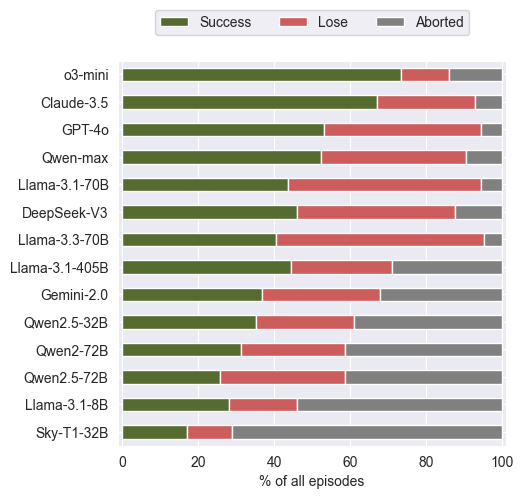

In [15]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

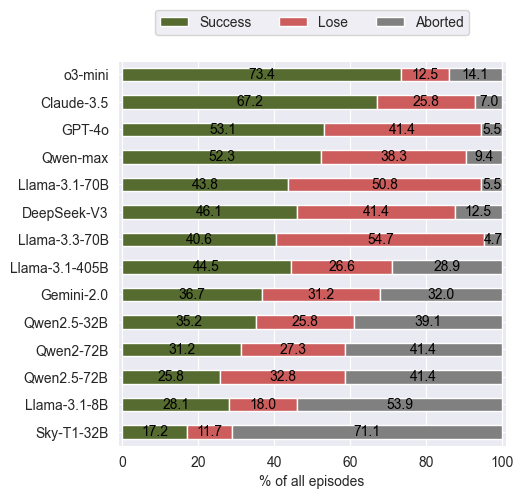

In [181]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

Bar plot with sorted clemscores:

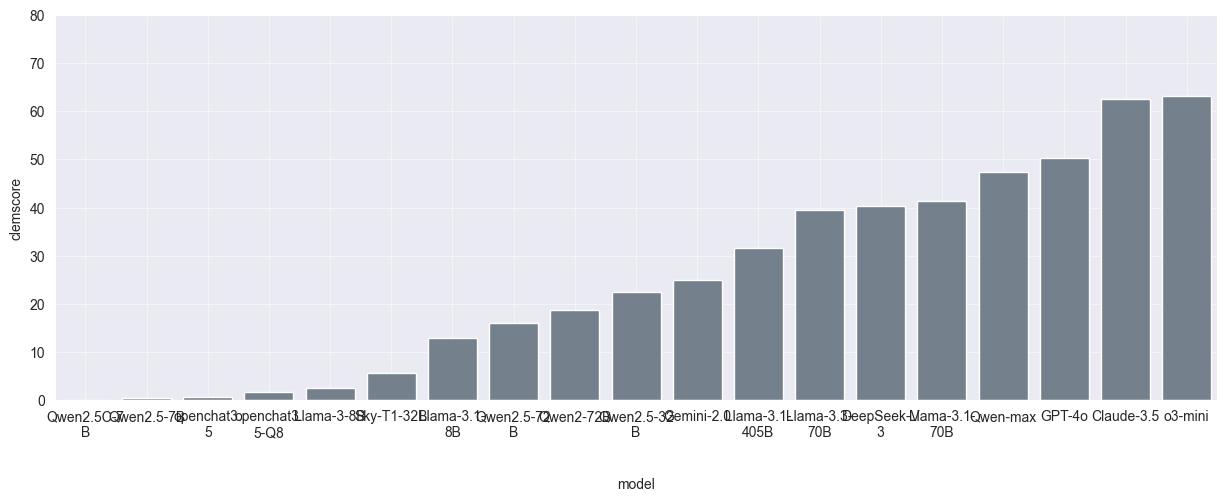

In [16]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 80)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [17]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
102139,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_5,Played,1.0
102140,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_6,Played,0.0
102141,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,Played,1.0
102142,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [18]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Claude-3.5,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Claude-3.5,basic-easy,episode_0,action_resolution_fail,0.0
46,adventuregame,Claude-3.5,basic-easy,episode_1,action_parsing_fail,0.0
47,adventuregame,Claude-3.5,basic-easy,episode_1,action_resolution_fail,0.0
87,adventuregame,Claude-3.5,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
99595,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,action_resolution_fail,9.0
99635,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,action_parsing_fail,47.0
99636,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,action_resolution_fail,0.0
99676,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_9,action_parsing_fail,0.0


Bar plot showing failures by phase for all models over all experiments:

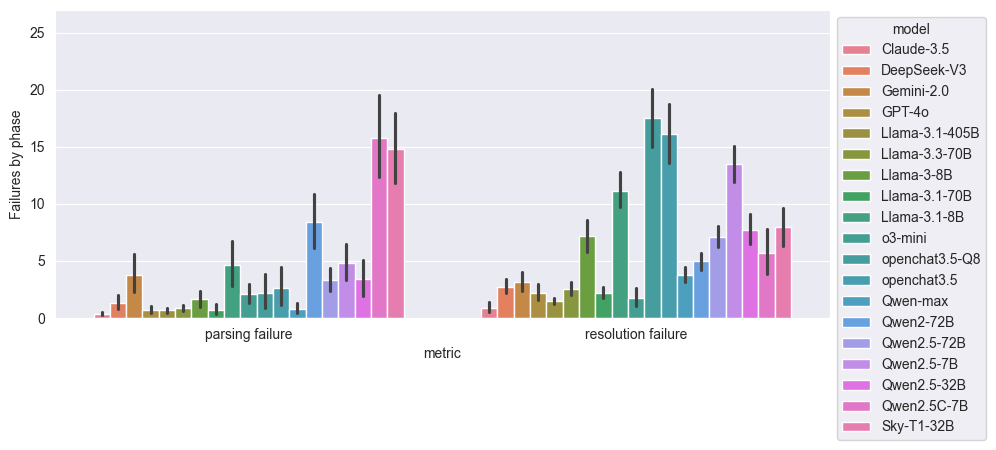

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [20]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Claude-3.5,2515.0
DeepSeek-V3,3367.0
GPT-4o,3094.0
Gemini-2.0,3335.0
Llama-3-8B,2683.0
Llama-3.1-405B,2407.0
Llama-3.1-70B,2975.0
Llama-3.1-8B,4905.0
Llama-3.3-70B,3026.0


Counts of failures by phase for all models over all experiments:

In [21]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model          metric                    
Claude-3.5     parsing failure       46.0
               resolution failure   112.0
DeepSeek-V3    parsing failure      171.0
               resolution failure   353.0
GPT-4o         parsing failure       94.0
               resolution failure   279.0
Gemini-2.0     parsing failure      487.0
               resolution failure   403.0
Llama-3-8B     parsing failure      212.0
               resolution failure   923.0
Llama-3.1-405B parsing failure       86.0
               resolution failure   190.0
Llama-3.1-70B  parsing failure       94.0
               resolution failure   282.0
Llama-3.1-8B   parsing failure      597.0
               resolution failure  1426.0
Llama-3.3-70B  parsing failure      108.0
               resolution failure   322.0
Qwen-max       parsing failure      103.0
               resolution failure   482.0
Qwen2-72B      parsing failure     1078.0
               resolution failure   636.0
Qwen2.5-32B    parsing failure      432.0
               resolution failure   986.0
Qwen2.5-72B    parsing failure      423.0
               resolution failure   908.0
Qwen2.5-7B     parsing failure      616.0
               resolution failure  1733.0
Qwen2.5C-7B    parsing failure     2018.0
               resolution failure   726.0
Sky-T1-32B     parsing failure     1900.0
               resolution failure  1019.0
o3-mini        parsing failure      274.0
               resolution failure   224.0
openchat3.5    parsing failure      338.0
               resolution failure  2063.0
openchat3.5-Q8 parsing failure      283.0
               resolution failure  2243.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [22]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model          metric                      
Claude-3.5     parsing failure     0.018290
               resolution failure  0.044533
DeepSeek-V3    parsing failure     0.050787
               resolution failure  0.104841
GPT-4o         parsing failure     0.030381
               resolution failure  0.090175
Gemini-2.0     parsing failure     0.146027
               resolution failure  0.120840
Llama-3-8B     parsing failure     0.079016
               resolution failure  0.344018
Llama-3.1-405B parsing failure     0.035729
               resolution failure  0.078936
Llama-3.1-70B  parsing failure     0.031597
               resolution failure  0.094790
Llama-3.1-8B   parsing failure     0.121713
               resolution failure  0.290724
Llama-3.3-70B  parsing failure     0.035691
               resolution failure  0.106411
Qwen-max       parsing failure     0.030276
               resolution failure  0.141681
Qwen2-72B      parsing failure     0.252814
               resolution failure  0.149156
Qwen2.5-32B    parsing failure     0.097605
               resolution failure  0.222775
Qwen2.5-72B    parsing failure     0.097668
               resolution failure  0.209651
Qwen2.5-7B     parsing failure     0.107994
               resolution failure  0.303822
Qwen2.5C-7B    parsing failure     0.364260
               resolution failure  0.131047
Sky-T1-32B     parsing failure     0.334507
               resolution failure  0.179401
o3-mini        parsing failure     0.093039
               resolution failure  0.076061
openchat3.5    parsing failure     0.078843
               resolution failure  0.481222
openchat3.5-Q8 parsing failure     0.063368
               resolution failure  0.502239

Overview/model comparison stacked bar plot for successful actions and failures by phase:

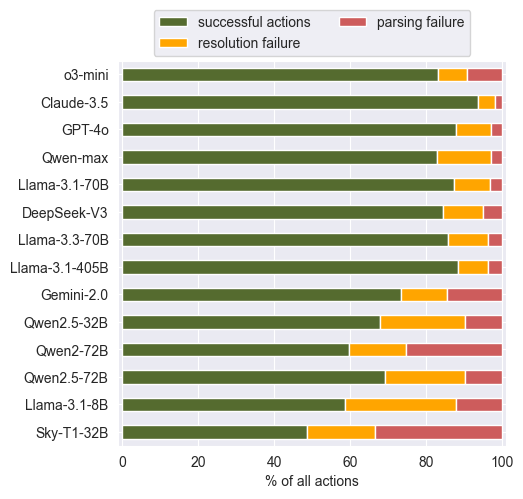

In [23]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/action_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [24]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model          metric                                
Claude-3.5     malformed command        2.0  0.000795
               out of grammar           0.0  0.000000
               undefined action type    0.0  0.000000
               undefined action verb   37.0  0.014712
               undefined antecedent     0.0  0.000000
...                                     ...       ...
openchat3.5-Q8 out of grammar           0.0  0.000000
               undefined action type    0.0  0.000000
               undefined action verb   97.0  0.021720
               undefined antecedent     0.0  0.000000
               undefined noun         129.0  0.028885

[114 rows x 2 columns]

In [25]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

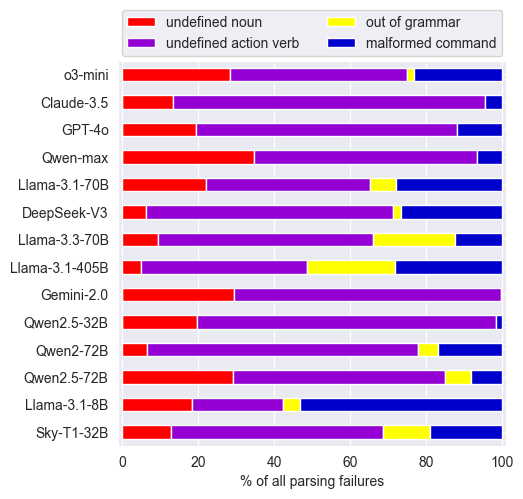

In [26]:
STACK_COLORS = ['red', 'darkviolet', 'yellow', 'mediumblue']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]



df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/parsing_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [27]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model          metric                                      
Claude-3.5     going to non-adjacent room    38.0  0.015109
               interacting with other room    1.0  0.000398
               manipulating room              0.0  0.000000
DeepSeek-V3    going to non-adjacent room   156.0  0.046332
               interacting with other room   28.0  0.008316
               manipulating room              0.0  0.000000
GPT-4o         going to non-adjacent room   109.0  0.035229
               interacting with other room    2.0  0.000646
               manipulating room              0.0  0.000000
Gemini-2.0     going to non-adjacent room    82.0  0.024588
               interacting with other room   13.0  0.003898
               manipulating room              5.0  0.001499
Llama-3-8B     going to non-adjacent room   130.0  0.048453
               interacting with other room    2.0  0.000745
               manipulating room              0.0  0.000000
Llama-3.1-405B going to non-adjacent room   117.0  0.048608
               interacting with other room    2.0  0.000831
               manipulating room              2.0  0.000831
Llama-3.1-70B  going to non-adjacent room   131.0  0.044034
               interacting with other room    7.0  0.002353
               manipulating room              0.0  0.000000
Llama-3.1-8B   going to non-adjacent room   326.0  0.066463
               interacting with other room   23.0  0.004689
               manipulating room              0.0  0.000000
Llama-3.3-70B  going to non-adjacent room   176.0  0.058163
               interacting with other room    2.0  0.000661
               manipulating room              0.0  0.000000
Qwen-max       going to non-adjacent room   272.0  0.079953
               interacting with other room    0.0  0.000000
               manipulating room              0.0  0.000000
Qwen2-72B      going to non-adjacent room   315.0  0.073874
               interacting with other room   19.0  0.004456
               manipulating room              0.0  0.000000
Qwen2.5-32B    going to non-adjacent room   410.0  0.092634
               interacting with other room    0.0  0.000000
               manipulating room              0.0  0.000000
Qwen2.5-72B    going to non-adjacent room   359.0  0.082891
               interacting with other room    2.0  0.000462
               manipulating room              0.0  0.000000
Qwen2.5-7B     going to non-adjacent room   420.0  0.073633
               interacting with other room   35.0  0.006136
               manipulating room              8.0  0.001403
Qwen2.5C-7B    going to non-adjacent room    41.0  0.007401
               interacting with other room    0.0  0.000000
               manipulating room              0.0  0.000000
Sky-T1-32B     going to non-adjacent room   312.0  0.054930
               interacting with other room    0.0  0.000000
               manipulating room              2.0  0.000352
o3-mini        going to non-adjacent room    45.0  0.015280
               interacting with other room    1.0  0.000340
               manipulating room              1.0  0.000340
openchat3.5    going to non-adjacent room   422.0  0.098437
               interacting with other room    2.0  0.000467
               manipulating room             52.0  0.012130
openchat3.5-Q8 going to non-adjacent room   245.0  0.054859
               interacting with other room   17.0  0.003807
               manipulating room             27.0  0.006046

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

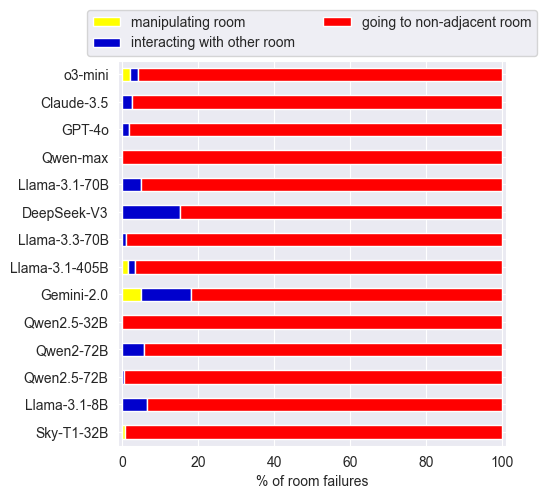

In [28]:
STACK_COLORS = ['yellow', 'darkviolet', 'red', 'mediumblue', 'yellow', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/nav_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [29]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model          metric                                       
Claude-3.5     entity already in inventory     7.0  0.002783
               entity not accessible          50.0  0.019881
               entity state mismatch           6.0  0.002386
               entity trait mismatch           0.0  0.000000
               inventory limit exceeded        5.0  0.001988
...                                            ...       ...
openchat3.5-Q8 entity already in inventory    13.0  0.002911
               entity not accessible        1552.0  0.347515
               entity state mismatch          76.0  0.017017
               entity trait mismatch           0.0  0.000000
               inventory limit exceeded       20.0  0.004478

[95 rows x 2 columns]

Overview/model comparison stacked bar plot for entity-related failures:

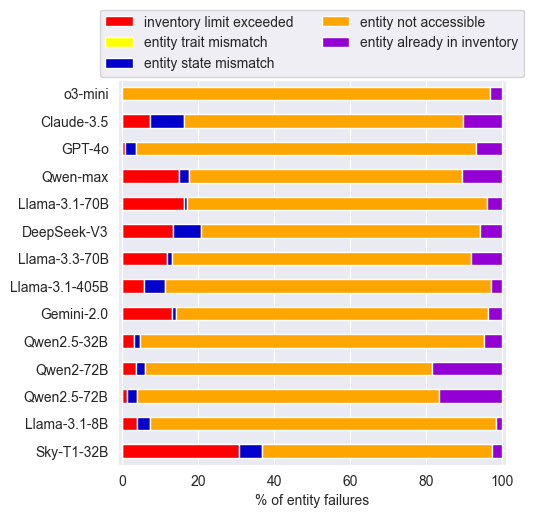

In [30]:
STACK_COLORS = ['red', 'yellow', 'khaki', 'mediumblue','orange',  'darkviolet']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/entity_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [31]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean        std  \
game          model          metric                                          
adventuregame Claude-3.5     Aborted                   0.070312   0.256678   
                             Lose                      0.257812   0.439149   
                             Main Score               67.187500  47.137552   
                             Parsed Request Count     19.648438   9.268174   
                             Played                    0.929688   0.256678   
...                                                         ...        ...   
              openchat3.5-Q8 undefined_action          0.000000   0.000000   
                             undefined_action_verb     0.757812   4.830588   
                             undefined_argument_type   0.000000   0.000000   
                             undefined_repr_str        1.007812   6.080168   
                             world_state_discrepancy   0.000000   0.000000   

                                                              var  median  \
game          model          metric                                         
adventuregame Claude-3.5     Aborted                     0.065883     0.0   
                             Lose                        0.192852     0.0   
                             Main Score               2221.948819   100.0   
                             Parsed Request Count       85.899053    18.5   
                             Played                      0.065883     1.0   
...                                                           ...     ...   
              openchat3.5-Q8 undefined_action            0.000000     0.0   
                             undefined_action_verb      23.334584     0.0   
                             undefined_argument_type     0.000000     0.0   
                             undefined_repr_str         36.968442     0.0   
                             world_state_discrepancy     0.000000     0.0   

                                                        max  min      skew  
game          model          metric                                         
adventuregame Claude-3.5     Aborted                    1.0  0.0  3.401216  
                             Lose                       1.0  0.0  1.120493  
                             Main Score               100.0  0.0 -0.740824  
                             Parsed Request Count      50.0  0.0  0.852785  
                             Played                     1.0  0.0 -3.401216  
...                                                     ...  ...       ...  
              openchat3.5-Q8 undefined_action           0.0  0.0  0.000000  
                             undefined_action_verb     42.0  0.0  7.483961  
                             undefined_argument_type    0.0  0.0  0.000000  
                             undefined_repr_str        44.0  0.0  6.518327  
                             world_state_discrepancy    0.0  0.0  0.000000  

[798 rows x 7 columns]

In [32]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean        std  \
game          model          metric                                         
adventuregame Claude-3.5     action_parsing_fail      0.359375   0.800928   
                             action_resolution_fail   0.875000   2.593147   
              DeepSeek-V3    action_parsing_fail      1.335938   3.611612   
                             action_resolution_fail   2.757812   3.619166   
              GPT-4o         action_parsing_fail      0.734375   1.709097   
                             action_resolution_fail   2.179688   4.472899   
              Gemini-2.0     action_parsing_fail      3.804688   9.498494   
                             action_resolution_fail   3.148438   4.788585   
              Llama-3-8B     action_parsing_fail      1.656250   4.249016   
                             action_resolution_fail   7.210938   8.121763   
              Llama-3.1-405B action_parsing_fail      0.671875   1.369576   
                             action_resolution_fail   1.484375   1.801069   
              Llama-3.1-70B  action_parsing_fail      0.734375   2.473432   
                             action_resolution_fail   2.203125   2.639373   
              Llama-3.1-8B   action_parsing_fail      4.664062  11.107405   
                             action_resolution_fail  11.140625   8.545141   
              Llama-3.3-70B  action_parsing_fail      0.843750   1.411078   
                             action_resolution_fail   2.515625   3.169700   
              Qwen-max       action_parsing_fail      0.804688   2.697501   
                             action_resolution_fail   3.765625   3.923449   
              Qwen2-72B      action_parsing_fail      8.421875  13.520244   
                             action_resolution_fail   4.968750   4.272117   
              Qwen2.5-32B    action_parsing_fail      3.375000   9.332021   
                             action_resolution_fail   7.703125   7.390523   
              Qwen2.5-72B    action_parsing_fail      3.304688   5.751492   
                             action_resolution_fail   7.093750   5.193026   
              Qwen2.5-7B     action_parsing_fail      4.812500   9.209504   
                             action_resolution_fail  13.539062   8.980208   
              Qwen2.5C-7B    action_parsing_fail     15.765625  21.302281   
                             action_resolution_fail   5.671875  11.474799   
              Sky-T1-32B     action_parsing_fail     14.843750  17.391480   
                             action_resolution_fail   7.960938   9.637037   
              o3-mini        action_parsing_fail      2.140625   5.155433   
                             action_resolution_fail   1.750000   4.325351   
              openchat3.5    action_parsing_fail      2.640625   9.376411   
                             action_resolution_fail  16.117188  14.847053   
              openchat3.5-Q8 action_parsing_fail      2.210938   8.501646   
                             action_resolution_fail  17.523438  14.814318   

                                                            var  median   max  \
game          model          metric                                             
adventuregame Claude-3.5     action_parsing_fail       0.641486     0.0   5.0   
                             action_resolution_fail    6.724409     0.0  24.0   
              DeepSeek-V3    action_parsing_fail      13.043738     0.0  28.0   
                             action_resolution_fail   13.098364     2.0  20.0   
              GPT-4o         action_parsing_fail       2.921014     0.0  13.0   
                             action_resolution_fail   20.006828     1.0  39.0   
              Gemini-2.0     action_parsing_fail      90.221395     0.0  44.0   
                             action_resolution_fail   22.930549     2.0  34.0   
              Llama-3-8B     action_parsing_fail      18.054134     0.5  22.0   
                             action_resolution_fail   65.963029     4.0  32.0   
     

Break results down by experiment:

In [33]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean  \
game          model          experiment             metric                             
adventuregame Claude-3.5     basic-easy             Aborted                   0.0000   
                                                    Lose                      0.2500   
                                                    Main Score               75.0000   
                                                    Parsed Request Count     12.4375   
                                                    Played                    1.0000   
...                                                                              ...   
              openchat3.5-Q8 planning-hard-invlimit undefined_action          0.0000   
                                                    undefined_action_verb     0.3125   
                                                    undefined_argument_type   0.0000   
                                                    undefined_repr_str        5.4375   
                                                    world_state_discrepancy   0.0000   

                                                                                   std  \
game          model          experiment             metric                               
adventuregame Claude-3.5     basic-easy             Aborted                   0.000000   
                                                    Lose                      0.447214   
                                                    Main Score               44.721360   
                                                    Parsed Request Count      2.032035   
                                                    Played                    0.000000   
...                                                                                ...   
              openchat3.5-Q8 planning-hard-invlimit undefined_action          0.000000   
                                                    undefined_action_verb     0.793200   
                                                    undefined_argument_type   0.000000   
                                                    undefined_repr_str       14.859200   
                                                    world_state_discrepancy   0.000000   

                                                                                     var  \
game          model          experiment             metric                                 
adventuregame Claude-3.5     basic-easy             Aborted                     0.000000   
                                                    Lose                        0.200000   
                                                    Main Score               2000.000000   
                                                    Parsed Request Count        4.129167   
                                                    Played                      0.000000   
...                                                                                  ...   
              openchat3.5-Q8 planning-hard-invlimit undefined_action            0.000000   
                                                    undefined_action_verb       0.629167   
                                                    undefined_argument_type     0.000000   
                                                    undefined_repr_str        220.795833   
                                                    world_state_discrepancy     0.000000   

                                                                             median  \
game          model          experiment             metric                            
adventuregame Claude-3.5     basic-easy             Aborted                     0.0   
                                                    Lose                        0.0   
                                                    Main Score                100.0   
                                                    Parsed Request Count       13.0   
                                             

In [34]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [35]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [36]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.5,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.5,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
102139,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_5,Played,1.0
102140,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_6,Played,0.0
102141,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,Played,1.0
102142,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,Played,0.0


In [37]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean              std           
metric                                 Played  Score    Played      Score
model          experiment                                                
Claude-3.5     basic-easy              1.0000  75.00  0.000000  44.721360
               basic-easy-invlimit     1.0000  68.75  0.000000  47.871355
               basic-hard              0.9375  75.00  0.250000  44.721360
               basic-hard-invlimit     0.9375  62.50  0.250000  50.000000
               planning-easy           0.9375  62.50  0.250000  50.000000
...                                       ...    ...       ...        ...
openchat3.5-Q8 basic-hard-invlimit     0.3125   0.00  0.478714   0.000000
               planning-easy           0.5000   6.25  0.516398  25.000000
               planning-easy-invlimit  0.1875   0.00  0.403113   0.000000
               planning-hard           0.2500   0.00  0.447214   0.000000
               planning-hard-invlimit  0.1250   0.00  0.341565   0.000000

[152 rows x 4 columns]

In [38]:
selected_stats_df.to_html("results/selected_stats.html")

In [39]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Limit to selected top models:

In [40]:
top_stats_df = game_df.drop(columns=["game"])
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "plan_average_viability_ratio", "hallucination_count"]')
top_stats_df = top_stats_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")
top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
# top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.rename({"achieved_goal_rating": "% Goals"})
top_stats_df = top_stats_df.rename({"plan_average_viability_ratio": "Plan Viability"})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', "% Lose")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df[('metric', 'Goal Rate')] = top_stats_df[('mean', '% Goals')]
top_stats_df[('metric', 'Plan Viability')] = top_stats_df[('mean', 'Plan Viability')] * 100
# top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', 'Plan Viability'), ('mean', "% Hal.")])
top_stats_df

metric                          \
metric                                clemscore Quality % Played % Lose   
model         experiment                                                  
Claude-3.5    basic-easy              75.000000   75.00   100.00  25.00   
              basic-easy-invlimit     68.750000   68.75   100.00  31.25   
              basic-hard              70.312500   75.00    93.75  18.75   
              basic-hard-invlimit     58.593750   62.50    93.75  31.25   
              planning-easy           58.593750   62.50    93.75  31.25   
              planning-easy-invlimit  68.750000   68.75   100.00  31.25   
              planning-hard           60.156250   68.75    87.50  18.75   
              planning-hard-invlimit  42.187500   56.25    75.00  25.00   
GPT-4o        basic-easy              68.750000   68.75   100.00  31.25   
              basic-easy-invlimit     75.000000   75.00   100.00  25.00   
              basic-hard              41.015625   43.75    93.75  50.00   
              basic-hard-invlimit     28.125000   37.50    75.00  43.75   
              planning-easy           62.500000   62.50   100.00  37.50   
              planning-easy-invlimit  62.500000   62.50   100.00  37.50   
              planning-hard           35.156250   37.50    93.75  56.25   
              planning-hard-invlimit  35.156250   37.50    93.75  56.25   
Llama-3.1-70B basic-easy              50.000000   50.00   100.00  50.00   
              basic-easy-invlimit     52.734375   56.25    93.75  37.50   
              basic-hard              35.156250   37.50    93.75  56.25   
              basic-hard-invlimit     32.812500   37.50    87.50  50.00   
              planning-easy           62.500000   62.50   100.00  37.50   
              planning-easy-invlimit  56.250000   56.25   100.00  43.75   
              planning-hard           16.406250   18.75    87.50  68.75   
              planning-hard-invlimit  29.296875   31.25    93.75  62.50   
Qwen2.5-32B   basic-easy              70.312500   75.00    93.75  18.75   
              basic-easy-invlimit     54.687500   62.50    87.50  25.00   
              basic-hard               6.250000   12.50    50.00  37.50   
              basic-hard-invlimit      1.562500    6.25    25.00  18.75   
              planning-easy           37.500000   50.00    75.00  25.00   
              planning-easy-invlimit  37.500000   50.00    75.00  25.00   
              planning-hard           12.500000   25.00    50.00  31.25   
              planning-hard-invlimit   3.906250   12.50    31.25  31.25   
o3-mini       basic-easy              76.171875   81.25    93.75  12.50   
              basic-easy-invlimit     76.171875   81.25    93.75  12.50   
              basic-hard              71.093750   81.25    87.50   6.25   
              basic-hard-invlimit     87.890625   93.75    93.75   0.00   
              planning-easy           55.859375   68.75    81.25  12.50   
              planning-easy-invlimit  50.781250   62.50    81.25  18.75   
              planning-hard           37.500000   50.00    75.00  25.00   
              planning-hard-invlimit  55.859375   68.75    81.25  12.50   

                                                                
metric                                Goal Rate Plan Viability  
model         experiment                                        
Claude-3.5    basic-easy              75.000000       0.000000  
              basic-easy-invlimit     68.750000       0.000000  
              basic-hard              91.666667       0.000000  
              basic-hard-invlimit     85.416667       0.000000  
              planning-easy           62.500000      16.763020  
              planning-easy-invlimit  68.750000      16.398306  
              planning-hard           85.416667       9.181268  
              planning-hard-invlimit  72.916667       5.722964  
GPT-4o        basic-easy              70.833333       0.000000  
              basic-easy-invlimit  

In [41]:
top_stats_df.to_html("results/top_model_experiment_stats.html")

In [42]:
top_stats_styled = top_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=1)
top_stats_styled.to_latex("results/top_model_experiment_stats.tex", clines="skip-last;data")

Planning variant:

In [43]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
656,adventuregame,Claude-3.5,planning-easy,episode_0,Violated Request Count,0.0
657,adventuregame,Claude-3.5,planning-easy,episode_0,Parsed Request Count,10.0
658,adventuregame,Claude-3.5,planning-easy,episode_0,Request Count,10.0
659,adventuregame,Claude-3.5,planning-easy,episode_0,Request Success Ratio,1.0
660,adventuregame,Claude-3.5,planning-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
102139,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_5,Played,1.0
102140,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_6,Played,0.0
102141,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,Played,1.0
102142,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,Played,0.0


In [44]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean                           std  \
metric                                    Adapt    Follow    Viable     Adapt   
model          experiment                                                       
Claude-3.5     planning-easy           0.985204  0.249798  0.167630  0.032262   
               planning-easy-invlimit  1.000000  0.247190  0.163983  0.000000   
               planning-hard           0.993750  0.165536  0.091813  0.025000   
               planning-hard-invlimit  1.000000  0.082187  0.057230  0.000000   
DeepSeek-V3    planning-easy           0.969818  0.160391  0.137243  0.039477   
...                                         ...       ...       ...       ...   
openchat3.5    planning-hard-invlimit  0.832500  0.231042  0.261313  0.147811   
openchat3.5-Q8 planning-easy           0.791684  0.287284  0.115625  0.149045   
               planning-easy-invlimit  0.860595  0.202321  0.125327  0.157319   
               planning-hard           0.857113  0.218199  0.174901  0.156985   
               planning-hard-invlimit  0.747708  0.335833  0.141537  0.239455   

                                                           
metric                                   Follow    Viable  
model          experiment                                  
Claude-3.5     planning-easy           0.106859  0.059183  
               planning-easy-invlimit  0.155333  0.108280  
               planning-hard           0.071526  0.035389  
               planning-hard-invlimit  0.068371  0.040368  
DeepSeek-V3    planning-easy           0.146942  0.103975  
...                                         ...       ...  
openchat3.5    planning-hard-invlimit  0.184362  0.283074  
openchat3.5-Q8 planning-easy           0.218426  0.147415  
               planning-easy-invlimit  0.229175  0.183386  
               planning-hard           0.196226  0.233401  
               planning-hard-invlimit  0.304746  0.170152  

[76 rows x 6 columns]

In [45]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [46]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Claude-3.5,basic-easy,episode_0,hallucination_count,0.0
45,adventuregame,Claude-3.5,basic-easy,episode_1,hallucination_count,0.0
86,adventuregame,Claude-3.5,basic-easy,episode_10,hallucination_count,0.0
127,adventuregame,Claude-3.5,basic-easy,episode_11,hallucination_count,1.0
168,adventuregame,Claude-3.5,basic-easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
99511,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_5,hallucination_count,1.0
99552,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_6,hallucination_count,0.0
99593,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_7,hallucination_count,0.0
99634,adventuregame,Sky-T1-32B,planning-hard-invlimit,episode_8,hallucination_count,0.0


In [47]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [48]:
openchat_hallu = hallucination_df.query('model == "openchat3.5" and value == 1')
openchat_hallu

,game,model,experiment,episode,metric,value
57732,adventuregame,openchat3.5,basic-easy,episode_0,hallucination_count,1.0
57814,adventuregame,openchat3.5,basic-easy,episode_10,hallucination_count,1.0
57896,adventuregame,openchat3.5,basic-easy,episode_12,hallucination_count,1.0
57978,adventuregame,openchat3.5,basic-easy,episode_14,hallucination_count,1.0
58019,adventuregame,openchat3.5,basic-easy,episode_15,hallucination_count,1.0
58060,adventuregame,openchat3.5,basic-easy,episode_2,hallucination_count,1.0
58347,adventuregame,openchat3.5,basic-easy,episode_9,hallucination_count,1.0
58429,adventuregame,openchat3.5,planning-easy,episode_1,hallucination_count,1.0
58634,adventuregame,openchat3.5,planning-easy,episode_14,hallucination_count,1.0
58757,adventuregame,openchat3.5,planning-easy,episode_3,hallucination_count,1.0


In [49]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:19, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Percentage'] = (hallucination_sums.value / 128) * 100
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Percentage
model,,
Claude-3.5,34.0,26.56250
DeepSeek-V3,54.0,42.18750
GPT-4o,54.0,42.18750
Gemini-2.0,47.0,36.71875
Llama-3-8B,46.0,35.93750
Llama-3.1-405B,41.0,32.03125
Llama-3.1-70B,65.0,50.78125
Llama-3.1-8B,23.0,17.96875
Llama-3.3-70B,71.0,55.46875


In [50]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [51]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Percentage", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [52]:
h_styled = hallucination_sums.style.format(subset="Percentage", precision=1).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [53]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Claude-3.5,0.265625,0.443401,0.196604,0.0,1.0,0.0,1.073950
DeepSeek-V3,0.421875,0.495799,0.245817,0.0,1.0,0.0,0.320150
GPT-4o,0.421875,0.495799,0.245817,0.0,1.0,0.0,0.320150
Gemini-2.0,0.367188,0.483932,0.234190,0.0,1.0,0.0,0.557601
Llama-3-8B,0.359375,0.481703,0.232037,0.0,1.0,0.0,0.593134
Llama-3.1-405B,0.320312,0.468430,0.219427,0.0,1.0,0.0,0.779368
Llama-3.1-70B,0.507812,0.501903,0.251907,1.0,1.0,0.0,-0.031626
Llama-3.1-8B,0.179688,0.385436,0.148561,0.0,1.0,0.0,1.688463
Llama-3.3-70B,0.554688,0.498953,0.248954,1.0,1.0,0.0,-0.222688


## Specific metrics plots
Bar plot overview by model and experiment:

In [54]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

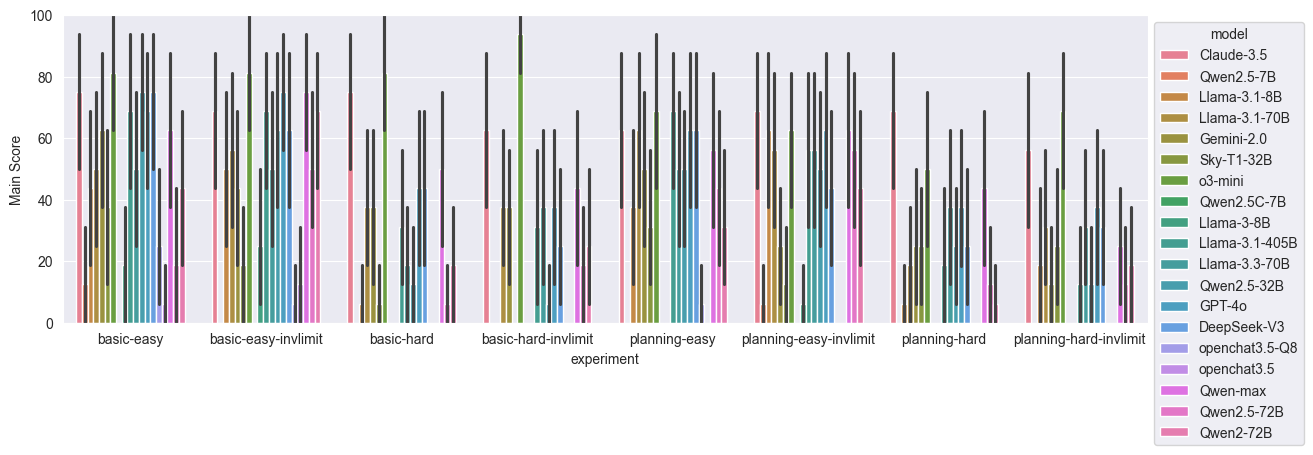

In [55]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


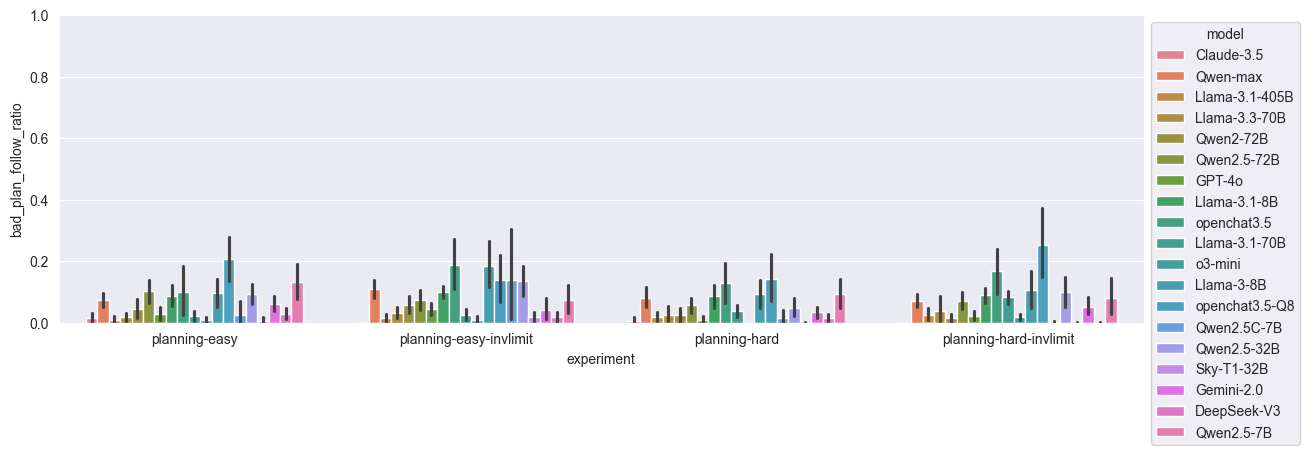

In [56]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


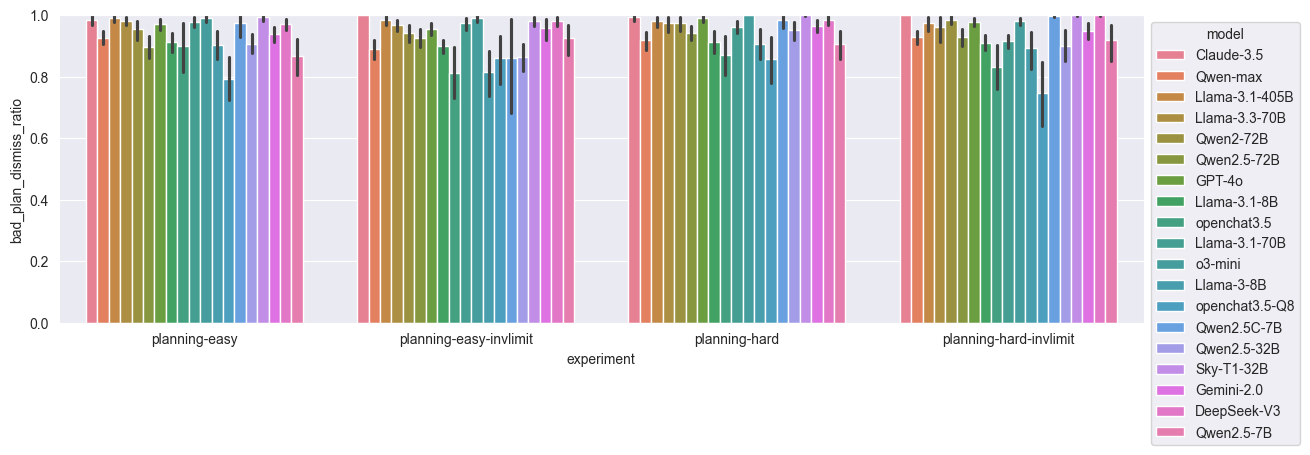

In [57]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


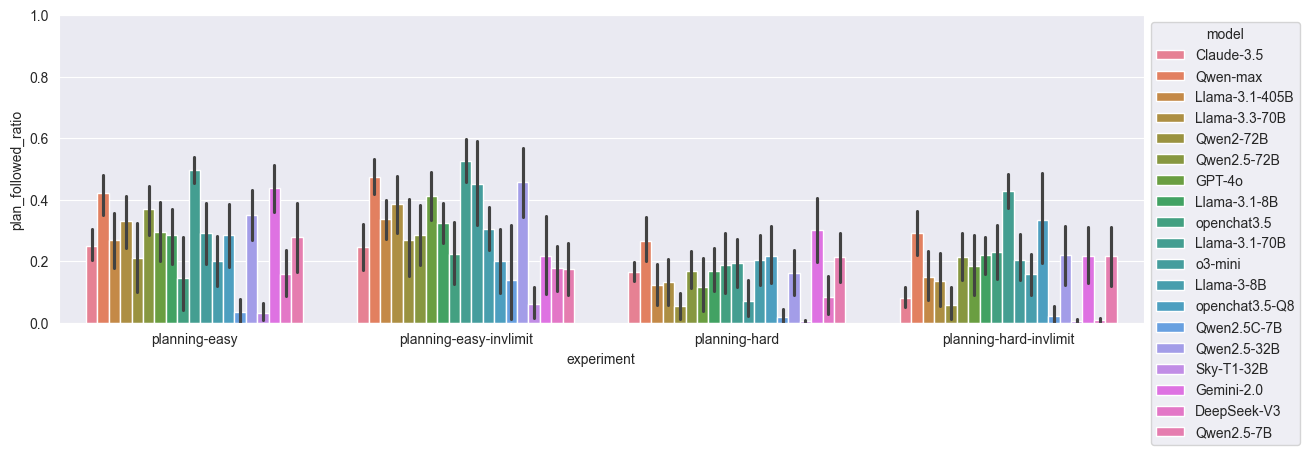

In [58]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


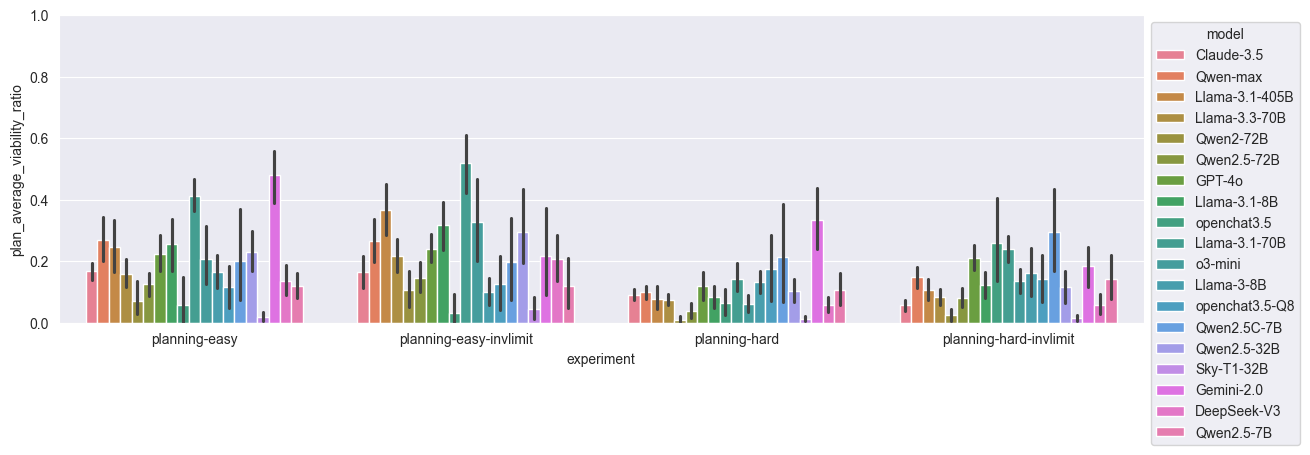

In [59]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

# Aborted episodes stacked bars

In [60]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

In [61]:
def get_episode_abort_metrics(model_id: str, variant: str, episode: str):
    abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    # load episode scores from JSON:
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    # check episode scores:
    ep_scores = scores['episode scores']
    if ep_scores["Aborted"] == 1:
        abort_dict["turn_limit"] = ep_scores["turn_limit_loss"]
    # check turn scores:
    turns_scores = scores['turn scores']
    for turn_scores in turns_scores.values():
        if turn_scores["command_tag_missing"] == 1:
            abort_dict["command_tag_missing"] = turn_scores["command_tag_missing"]
            if turn_scores["hallucination"] == 1:
                abort_dict["hallucination"] = turn_scores["hallucination"]
            break
        if turn_scores["next_actions_missing"] == 1:
            abort_dict["next_actions_missing"] = turn_scores["next_actions_missing"]
            break

    return abort_dict

In [62]:
model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
variant = "1_home_deliver_three_planning_easy"
# episode = "episode_3"
episode = "episode_9"
get_episode_abort_metrics(model_id, variant, episode)

{'turn_limit': 0,
 'command_tag_missing': 1,
 'next_actions_missing': 0,
 'hallucination': 0}

In [63]:
def get_abort_metrics(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    overall_abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    for variant in variants:
        for episode in episodes:
            cur_abort_dict = get_episode_abort_metrics(model_id, variant, episode)
            for key, val in cur_abort_dict.items():
                # print(key, val)
                overall_abort_dict[key] += val

    return overall_abort_dict

In [64]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

get_abort_metrics("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants)

{'turn_limit': 9,
 'command_tag_missing': 9,
 'next_actions_missing': 0,
 'hallucination': 0}

In [65]:
def get_model_set_abort_metrics(model_ids: list, variants: list):
    abort_totals = dict()
    for model_id in model_ids:
        overall_abort_dict = get_abort_metrics(model_id, variants)
        abort_totals[model_name_dict[model_id]] = overall_abort_dict

    return abort_totals

In [66]:
all_models_all_abort = get_model_set_abort_metrics(final_models, variants)
all_models_all_abort

{'Claude-3.5': {'turn_limit': 2,
  'command_tag_missing': 7,
  'next_actions_missing': 0,
  'hallucination': 1},
 'o3-mini': {'turn_limit': 9,
  'command_tag_missing': 9,
  'next_actions_missing': 0,
  'hallucination': 0},
 'GPT-4o': {'turn_limit': 7,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen-max': {'turn_limit': 12,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.1-70B': {'turn_limit': 5,
  'command_tag_missing': 2,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.3-70B': {'turn_limit': 5,
  'command_tag_missing': 1,
  'next_actions_missing': 0,
  'hallucination': 1},
 'DeepSeek-V3': {'turn_limit': 11,
  'command_tag_missing': 4,
  'next_actions_missing': 1,
  'hallucination': 0},
 'Llama-3.1-405B': {'turn_limit': 1,
  'command_tag_missing': 26,
  'next_actions_missing': 10,
  'hallucination': 7},
 'Qwen2.5-32B': {'turn_limit': 45,
  'command_tag_missing': 5,
  'next_actions_missing': 0

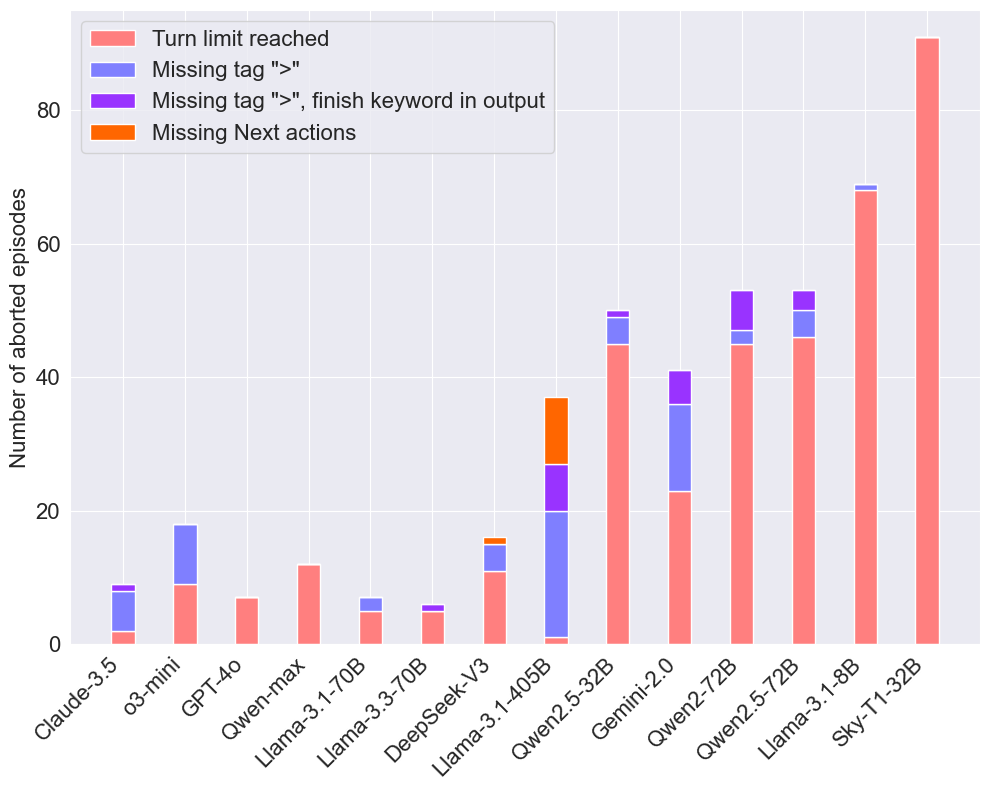

In [67]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

# Prepare data for plotting
models = list()

turn_limit_losses = list()
command_tag_missings = list()
next_actions_missings = list()
hallucinations = list()

# opponent_faster_losses = []

for model_name, abort_data in all_models_all_abort.items():
    # Create shorter model name for display
    # short_name = model_name.split('-t0.0--')[0].split('-2024')[0].split('-2025')[0].replace('-Instruct', '').replace('-flash-exp', '').replace('-sonnet', '')
    models.append(model_name)

    # Get abort counts, default to 0 if not present
    turn_limit_losses.append(abort_data.get('turn_limit', 0))
    command_tag_missings.append(abort_data.get('command_tag_missing', 0))
    next_actions_missings.append(abort_data.get('next_actions_missing', 0))
    hallucinations.append(abort_data.get('hallucination', 0))

# print(models)

turn_limit_losses = np.array(turn_limit_losses)
command_tag_missings = np.array(command_tag_missings)
next_actions_missings = np.array(next_actions_missings)
hallucinations = np.array(hallucinations)

hallu_sub_tag_missings = command_tag_missings - hallucinations

# Set up the plot
plt.figure(figsize=(10, 8))

# Set the width of each bar and positions of the bars
width = 0.3
x = np.arange(len(models)) * 0.8  # Reduce spacing between bars

plt.ylim([0,95])

# Create the stacked bars
plt.bar(x, turn_limit_losses, width, label='Turn limit reached', color='#ff7f7f')
plt.bar(x, hallu_sub_tag_missings, width, bottom=turn_limit_losses, label='Missing tag ">"', color='#7f7fff')
plt.bar(x, hallucinations, width, bottom=hallu_sub_tag_missings + turn_limit_losses, label='Missing tag ">", finish keyword in output', color='#9933FF')
plt.bar(x, next_actions_missings, width, bottom=hallu_sub_tag_missings + turn_limit_losses + hallucinations, label='Missing Next actions', color='#FF6600')

# Customize the plot
plt.ylabel('Number of aborted episodes', fontsize=16)
# plt.title('Abort Distribution by Model', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('results/aborts_distribution.pdf', dpi=300, bbox_inches='tight')

# plt.close()
plt.show()

## Exploration

In [68]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

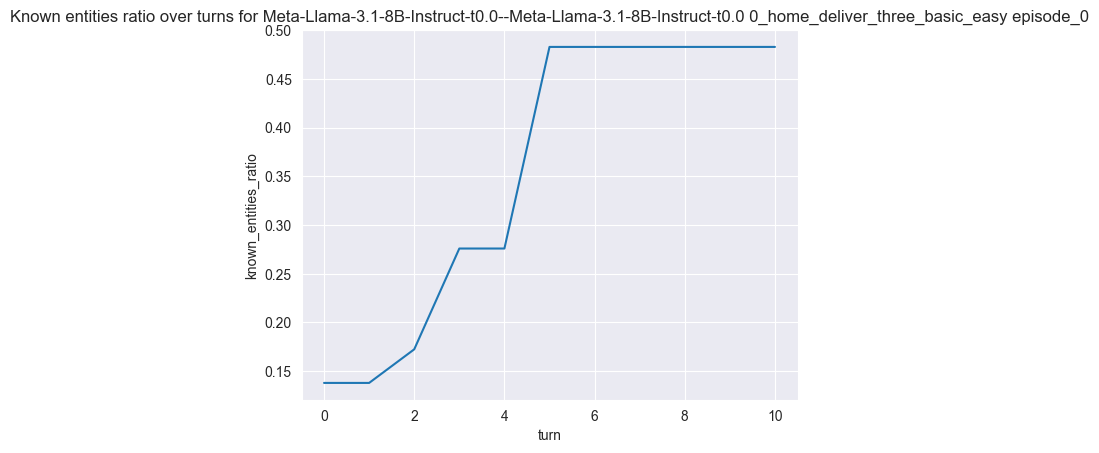

In [69]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [70]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

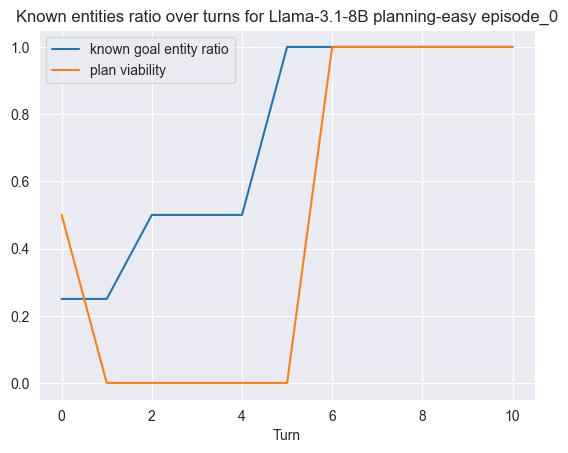

In [71]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

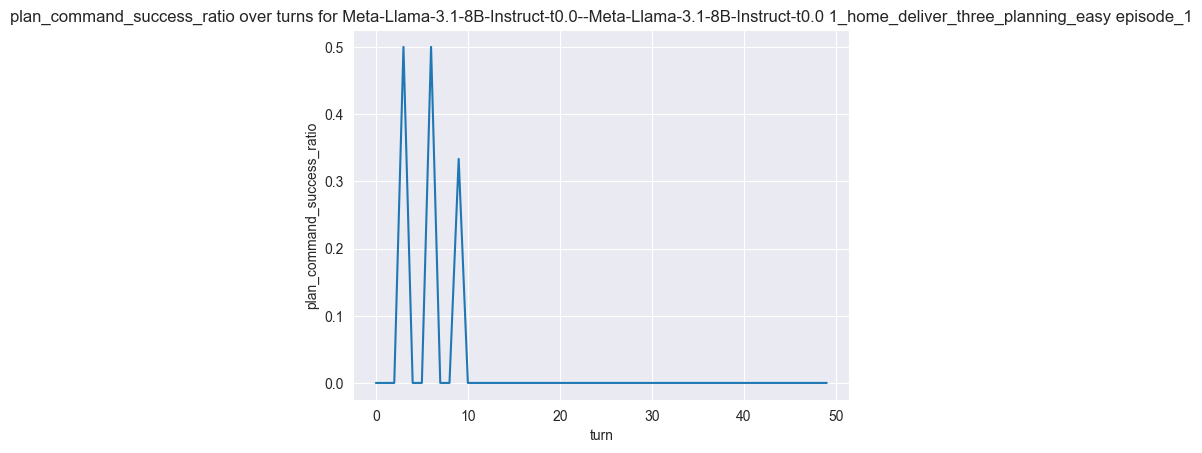

In [72]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_1"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='plan_command_success_ratio',
       title=f'plan_command_success_ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [73]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

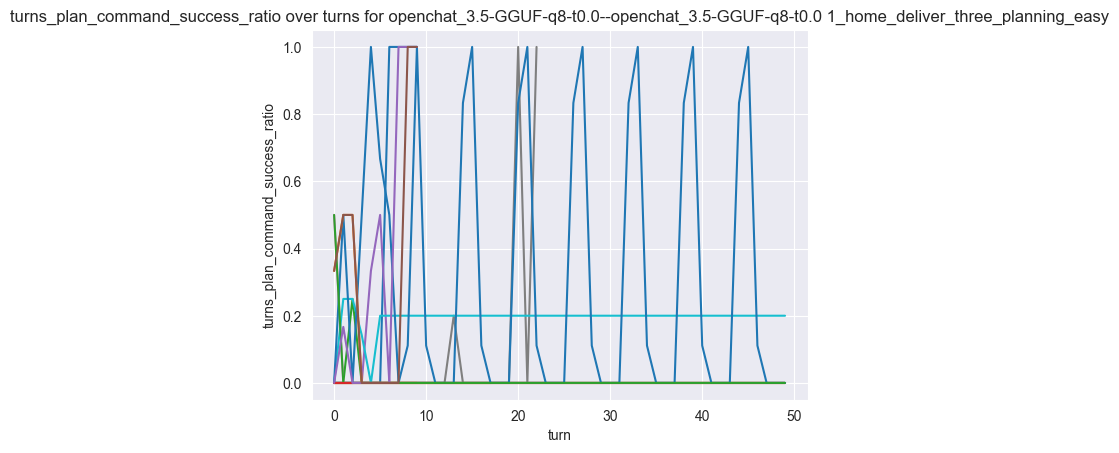

In [74]:
# model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

fig, ax = plt.subplots()

for episode in episodes:
    turns_plan_command_success_ratio = get_score_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='turns_plan_command_success_ratio',
       title=f'turns_plan_command_success_ratio over turns for {model_id} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [75]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

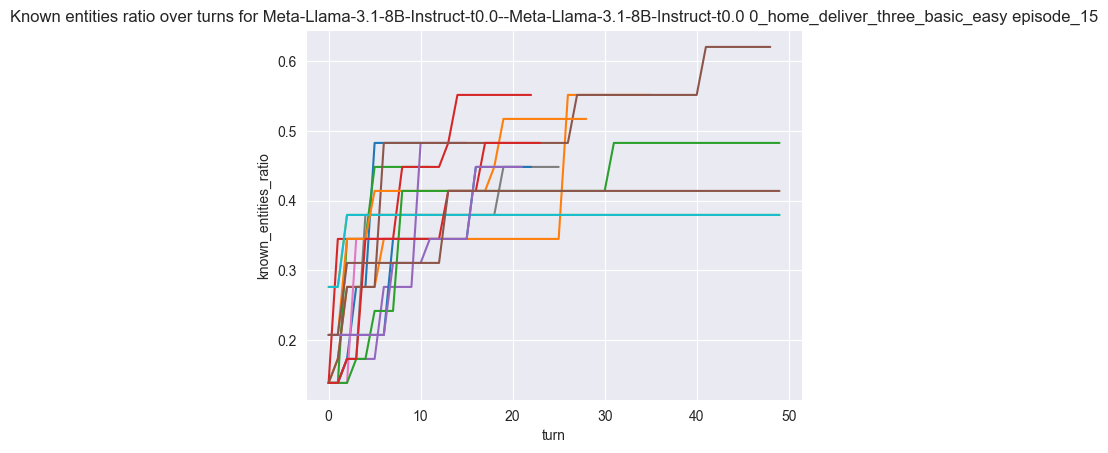

In [76]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

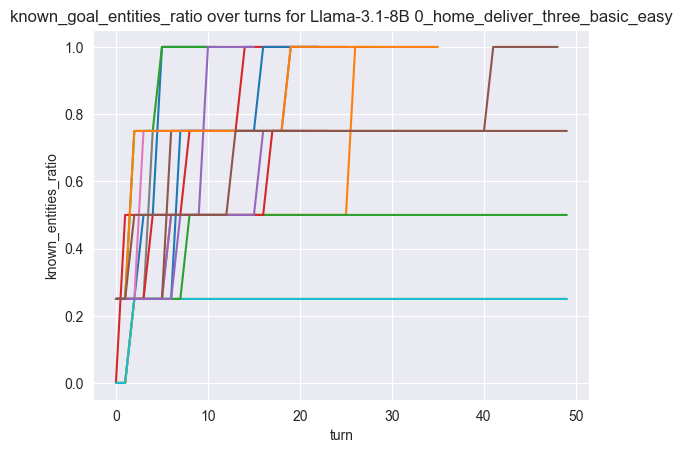

In [77]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [78]:
def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

In [79]:
# get episodes/plan viability progression for one model
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    list_of_progress_lists.append(plan_viability_progress_list)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_0 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_0.append(turn_sum / 16)

avg_last_ten_0


[0.11458333333333333,
 0.078125,
 0.140625,
 0.11458333333333333,
 0.11458333333333333,
 0.34375,
 0.46875,
 0.4895833333333333,
 0.3875,
 0.36458333333333337]

In [80]:
# get episodes/plan viability progression for one model
model_id = "Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    list_of_progress_lists.append(plan_viability_progress_list)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_1 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_1.append(turn_sum / 16)

avg_last_ten_1


[0.08333333333333333,
 0.09375,
 0.08333333333333333,
 0.11666666666666665,
 0.19895833333333335,
 0.28125,
 0.6145833333333334,
 0.59375,
 0.59375,
 0.125]

In [81]:
# get episodes/plan viability progression for one model
model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

list_of_progress_lists = list()

ep_count = 0

for episode in episodes:
    plan_viability_progress_list = get_exploration_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    if len(plan_viability_progress_list) >= 10:
        list_of_progress_lists.append(plan_viability_progress_list)
        ep_count += 1

# print(ep_count)

last_ten = [ep_list[-10:] for ep_list in list_of_progress_lists]

avg_last_ten_2 = list()

for turn_idx in range(10):
    turn_sum = sum([turn[turn_idx] for turn in last_ten])
    avg_last_ten_2.append(turn_sum / ep_count)

avg_last_ten_2

[0.057692307692307696,
 0.13150183150183148,
 0.17673992673992672,
 0.26794871794871794,
 0.22692307692307695,
 0.5512820512820513,
 0.48717948717948717,
 0.5384615384615384,
 0.3076923076923077,
 0.07692307692307693]

## Over all turns

In [82]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            turns_score.append(turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [83]:
get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3


[0.13793103448275862, nan]

In [84]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [85]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")

array([0.0687004 , 0.07052951, 0.11301998, 0.15367406, 0.14420498,
       0.17010126, 0.18791735, 0.15876437, 0.15720551, 0.14940476,
       0.18484848, 0.24338624, 0.22592593, 0.24166667, 0.22038095,
       0.234375  , 0.18115942, 0.13518519, 0.14268293, 0.18947368,
       0.14380952, 0.11764706, 0.0862069 , 0.08333333, 0.03333333,
       0.04924242, 0.17063492, 0.14285714, 0.14166667, 0.08854167,
       0.17948718, 0.22222222, 0.08333333, 0.13636364, 0.225     ,
       0.02      , 0.03571429, 0.03571429, 0.05952381, 0.04761905,
       0.07142857, 0.05555556, 0.05555556, 0.        , 0.11111111,
       0.05555556, 0.05555556, 0.05      , 0.        , 0.        ])

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


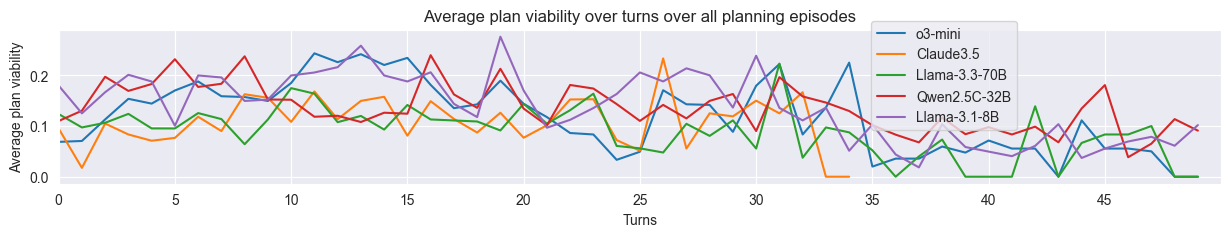

In [86]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.1-8B")

ax.set(xlabel='Turns', ylabel='Average plan viability',
       title=f'Average plan viability over turns over all planning episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")


# fig.savefig("results/top_models_plan_viability_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/comp_models_plan_viability_all.pdf", format="pdf", bbox_inches="tight")
# fig.savefig("results/top_models_plan_viability_all.png")
fig.savefig("results/comp_models_plan_viability_all.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


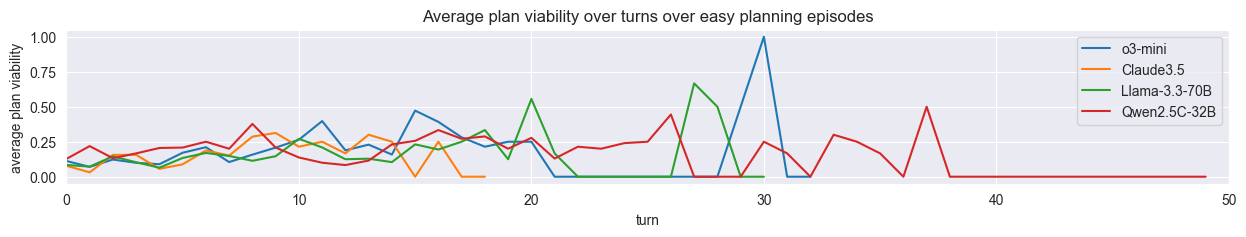

In [87]:
variants = ["1_home_deliver_three_planning_easy"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over easy planning episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_easy.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_easy.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


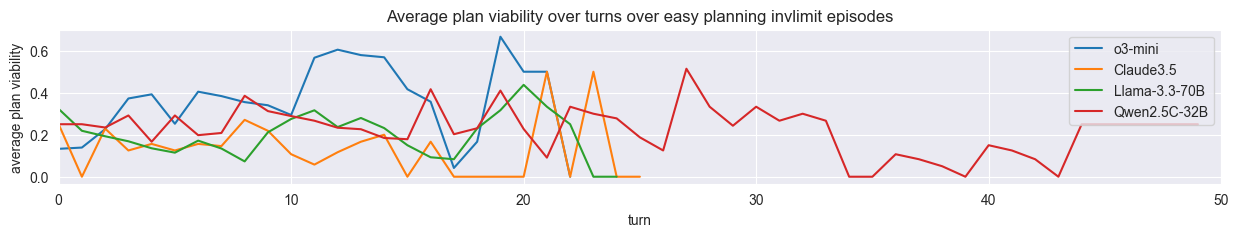

In [88]:
variants = ["3_home_deliver_three_planning_easy_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over easy planning invlimit episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_easy_invlimit.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_easy_invlimit.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


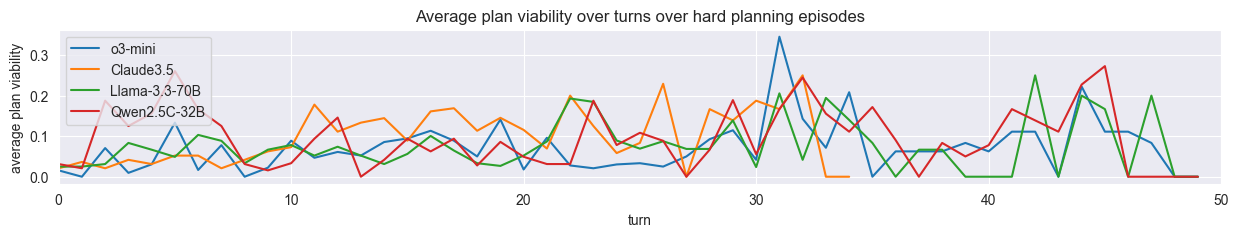

In [89]:
variants = ["5_home_deliver_three_planning_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over hard planning episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_hard.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_hard.png")

plt.show()

C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


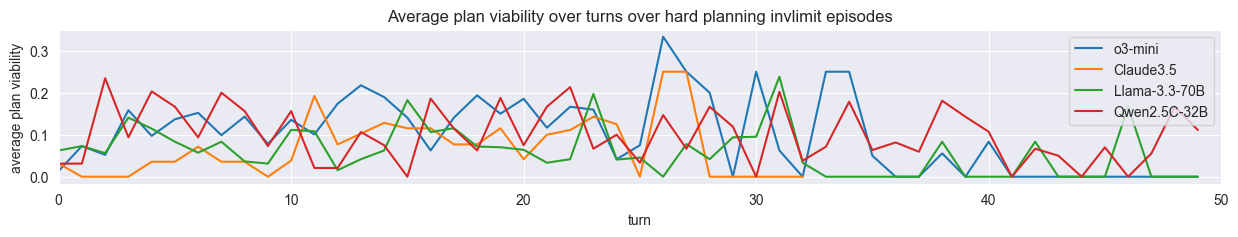

In [90]:
variants = ["7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio"), label="Qwen2.5C-32B")

ax.set(xlabel='turn', ylabel='average plan viability',
       title=f'Average plan viability over turns over hard planning invlimit episodes')
# ax.grid()

plt.xlim([0,50])

plt.legend()

fig.savefig("results/top_models_plan_viability_hard_invlimit.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_plan_viability_hard_invlimit.png")

plt.show()

#### Combined plan viability + plan following

In [91]:
def get_viab_follow_progress_list(model_id: str, variant: str, episode: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()

    # print(turn_scores)

    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):

        # print(turn_scores.values())

        success_ratio_found = False
        plan_follow_found = False
        plan_compound = np.nan

        if turn_idx < 1:
            continue

        if "plan_command_success_ratio" in turn_scores_value:
            success_ratio_found = True
            # turns_score.append(turn_scores_value[score])
        else:
            print(f"plan_command_success_ratio not in turn {turn_idx} of {model_id} {variant} {episode}")
            # turns_score.append(np.nan)

        print(f"looking at turn {str(turn_idx+1)}:")

        if str(turn_idx+1) in turn_scores:
            print(f"turn {str(turn_idx+1)} is in turn_scores")
            # if "plan_followed" in turn_scores[str(turn_idx+1)].values():
            if "plan_followed" in turn_scores[str(turn_idx+1)]:
                plan_follow_found = True
            else:
                print(f"plan_followed not in turn {turn_idx+1} of {model_id} {variant} {episode}")
        else:
            print(f"no turn {turn_idx+1} in {model_id} {variant} {episode}")

        if success_ratio_found and plan_follow_found:
            print(f"following plan followed there, calulcating compound!")
            # plan_compound = turn_scores_value["plan_command_success_ratio"] + turn_scores[str(turn_idx+1)].values()["plan_followed"]
            plan_compound = turn_scores_value["plan_command_success_ratio"] + turn_scores[str(turn_idx+1)]["plan_followed"]
        else:
            print(f"following plan followed not found!")

        turns_score.append(plan_compound)

    return turns_score

In [92]:
get_viab_follow_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0")

looking at turn 2:
turn 2 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 3:
turn 3 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 4:
turn 4 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 5:
turn 5 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 6:
turn 6 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 7:
turn 7 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 8:
turn 8 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 9:
turn 9 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 10:
turn 10 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 11:
turn 11 is in turn_scores
following plan followed there, calulcating compound!
looking at turn 12:
turn 1

[0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.5,
 2.0,
 1.0,
 0.0,
 2.0,
 1.5,
 1.5,
 0.0,
 nan]

In [93]:
def get_avg_plan_compound(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_viab_follow_progress_list(model_id, variant, episode)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

### Last ten turns

In [94]:
def get_avg_last_turns_score(model_id: str, variants: list, score: str, n_turns: int):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_progress_lists = list()
    ep_count = 0
    for variant in variants:
        for episode in episodes:
            plan_viability_progress_list = get_score_progress_list(model_id, variant, episode, score)
            if len(plan_viability_progress_list) >= n_turns:
                list_of_progress_lists.append(plan_viability_progress_list)
                ep_count += 1
    print(f"{ep_count} viable episodes for {model_id}")
    last_n = [ep_list[-n_turns:] for ep_list in list_of_progress_lists]
    avg_last_n = list()
    for turn_idx in range(n_turns):
        turn_sum = sum([turn[turn_idx] for turn in last_n])
        avg_last_n.append(turn_sum / ep_count)

    return avg_last_n

In [95]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
            "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

get_avg_last_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio", 10)

56 viable episodes for o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0


[0.12421343537414965,
 0.11985544217687075,
 0.17708333333333331,
 0.1880952380952381,
 0.23571428571428574,
 0.3571428571428571,
 0.3785714285714285,
 0.47023809523809523,
 0.3482142857142857,
 0.017857142857142856]

56 viable episodes for o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0
61 viable episodes for claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0
62 viable episodes for Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0
64 viable episodes for Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0
63 viable episodes for Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0


C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\2956393704.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(reverse_turns)


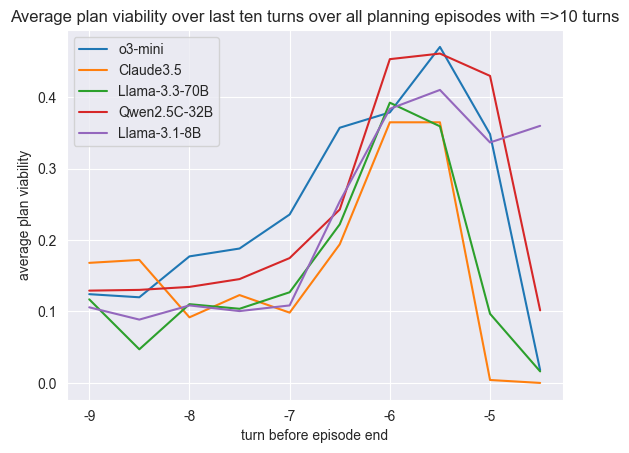

In [96]:
fig, ax = plt.subplots()

ax.plot(get_avg_last_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio", 10), label="o3-mini")
ax.plot(get_avg_last_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "plan_command_success_ratio", 10), label="Claude3.5")
ax.plot(get_avg_last_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Llama-3.3-70B")
ax.plot(get_avg_last_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Qwen2.5C-32B")
ax.plot(get_avg_last_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "plan_command_success_ratio", 10), label="Llama-3.1-8B")

ax.set(xlabel='turn before episode end', ylabel='average plan viability',
       title=f'Average plan viability over last ten turns over all planning episodes with =>10 turns')
# ax.grid()

reverse_turns = ["-10", "-9", "-8", "-7", "-6", "-5", "-4", "-3", "-2", "-1"]

# ax.set_ticks(reverse_turns)

ax.set_xticklabels(reverse_turns)

plt.legend()

fig.savefig("results/plan_viability_last_ten_turns.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Epistemic/Pragmatic

In [97]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio")

known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
known_entities_ratio not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15


C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\3033359787.py:13: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


array([0.16810345, 0.23399015, 0.26600985, 0.31034483, 0.36206897,
       0.39655172, 0.42364532, 0.42857143, 0.45092838, 0.48806366,
       0.5066313 , 0.51193634, 0.51724138, 0.56034483, 0.57241379,
       0.58237548, 0.61206897, 0.61206897, 0.60591133, 0.64367816,
       0.68103448, 0.68103448, 0.62068966, 0.62068966, 0.62068966,
       0.55172414, 0.55172414, 0.55172414, 0.55172414, 0.55172414,
       0.55172414, 0.55172414, 0.55172414,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
known_entities_ratio not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
known_entities_ratio not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
known_entities_ratio not in 

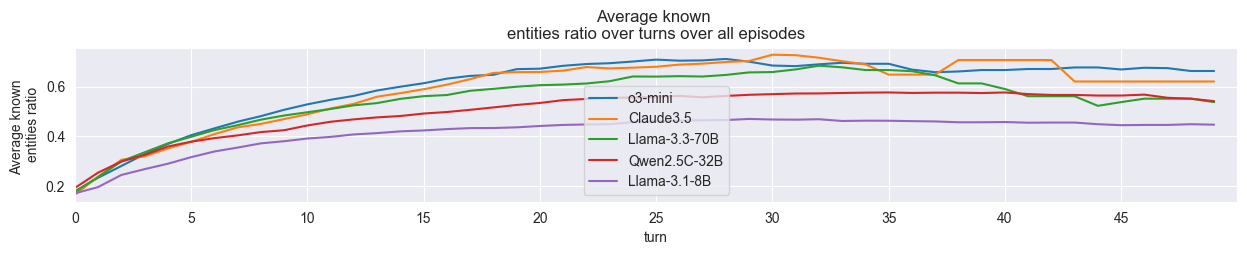

In [98]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")

metric_name = "known \nentities ratio"

ax.set(xlabel='turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


# plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")
# plt.legend()
plt.legend(loc="lower center")

fig.savefig("results/top_models_known_entities_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_known_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
known_goal_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
known_goal_entities_ratio not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
known_goal_entities_ratio not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
known_goal_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
known_goal_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
known_goal_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo epi

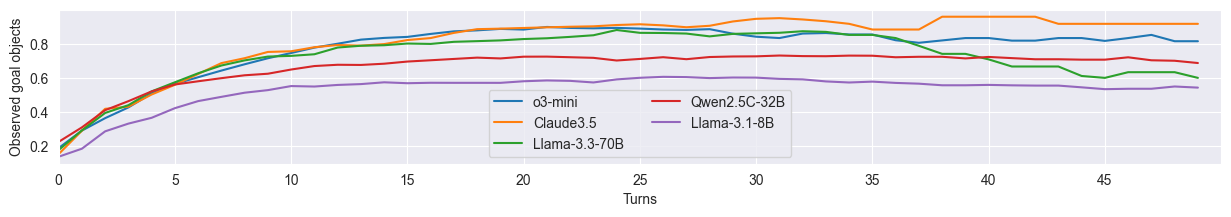

In [99]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "known_goal_entities_ratio"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Observed goal objects"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2, loc='lower center')

fig.savefig("results/known_goal_entities_ratio.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/known_goal_entities_ratio.png")

plt.show()

visited_rooms_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
visited_rooms_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
visited_rooms_ratio not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
visited_rooms_ratio not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
visited_rooms_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
visited_rooms_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
visited_rooms_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
visited_rooms_ratio not in turn 1 o

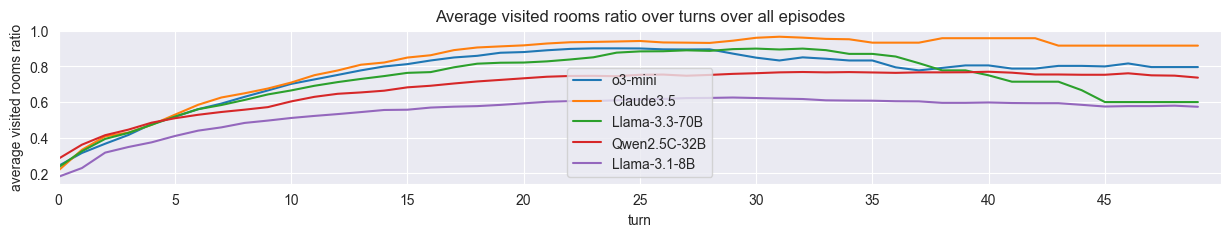

In [100]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "visited_rooms_ratio"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "visited rooms ratio"

ax.set(xlabel='turn', ylabel=f'average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_visited_rooms_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_visited_rooms_ratio_all.png")

plt.show()

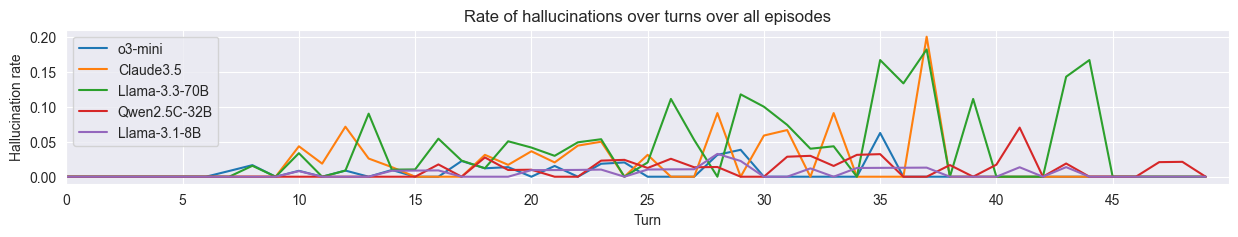

In [101]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "hallucination"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "hallucinations"

ax.set(xlabel='Turn', ylabel=f'Hallucination rate',
       title=f'Rate of {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_hallucinations_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_hallucinations_all.png")

plt.show()

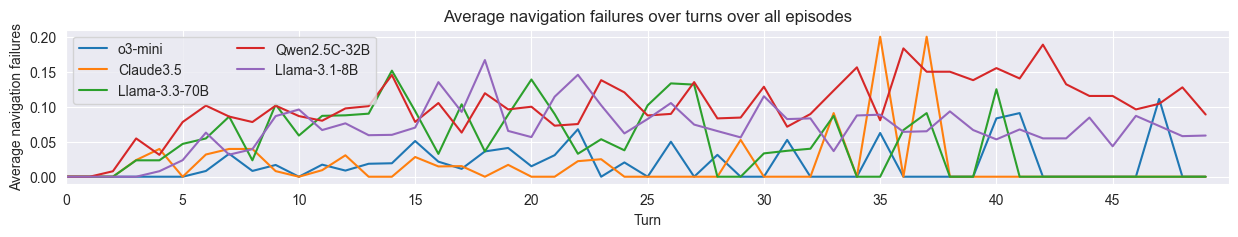

In [102]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "no_exit_to"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "navigation failures"

ax.set(xlabel='Turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

fig.savefig("results/top_models_nav_fail_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_nav_fail_all.png")

plt.show()

In [103]:
def get_min_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    min_array = np.nanmin(progress_array, axis=0)

    return min_array

In [104]:
def get_median_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    median_array = np.nanmedian(progress_array, axis=0)

    return median_array

In [105]:
def get_max_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0, 16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    max_array = np.nanmax(progress_array, axis=0)

    return max_array

In [106]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

get_min_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [107]:
get_median_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [108]:
get_max_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])

### Accumulative

In [109]:
def get_score_progress_list_acc(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            if turn_idx == 0:
                turns_score.append(turn_scores_value[score])
            else:
                turns_score.append(turns_score[turn_idx-1] + turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [110]:
def get_avg_turns_score_acc(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list_acc(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)
    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [111]:
get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]

In [112]:
get_score_progress_list_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

[0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6]

In [113]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")

epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
epistemic_action not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15


C:\Users\JJ\AppData\Local\Temp\ipykernel_21520\482713200.py:12: RuntimeWarning: Mean of empty slice
  averages_array = np.nanmean(progress_array, axis=0)


array([ 0.5625    ,  1.35714286,  1.85714286,  2.35714286,  2.92857143,
        3.57142857,  4.14285714,  4.71428571,  5.53846154,  6.15384615,
        6.76923077,  7.30769231,  7.69230769,  8.25      ,  9.4       ,
       10.11111111, 10.75      , 11.        , 11.14285714, 11.16666667,
       11.5       , 11.5       , 11.        , 11.        , 11.        ,
       11.        , 12.        , 13.        , 13.        , 13.        ,
       13.        , 13.        , 13.        ,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
epistemic_action not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
epistemic_action not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.

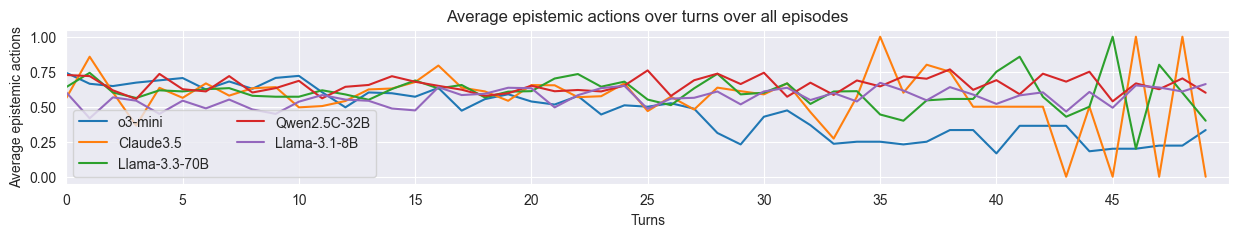

In [114]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.legend()
plt.legend(loc="lower left", ncols=2)

fig.savefig("results/top_models_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_epistemic_actions_all.png")

plt.show()

epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
epistemic_action not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
epistemic_action not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.

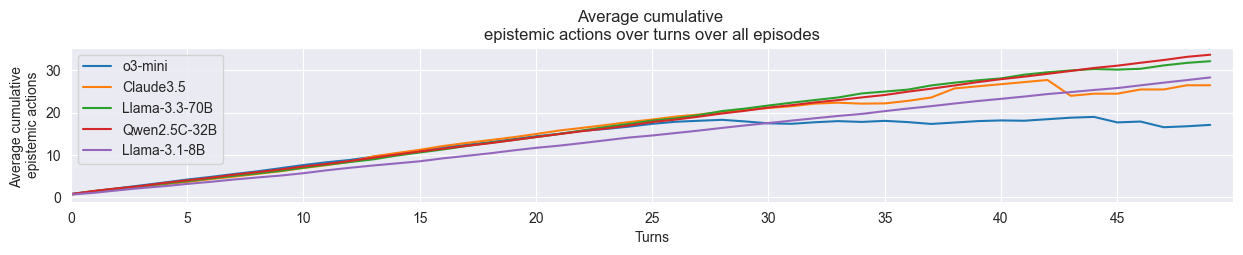

In [115]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "cumulative \nepistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_cumulative_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_cumulative_epistemic_actions_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
effective_epistemic_gain_amount not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
effective_epistemic_gain_amount not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_d

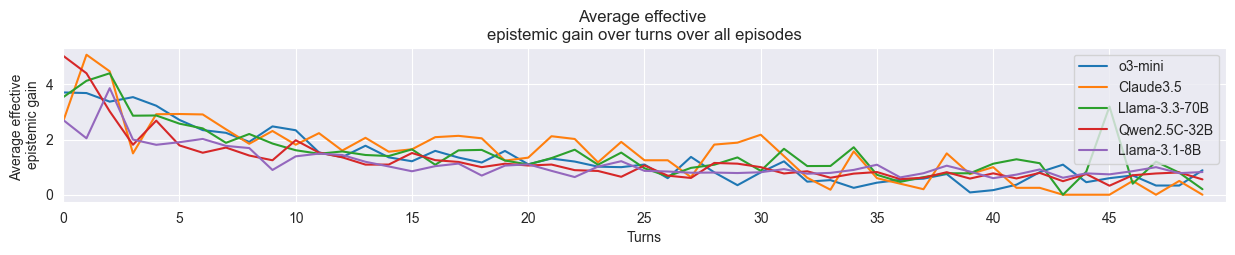

In [116]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "effective \nepistemic gain"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_gain"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
effective_epistemic_gain_amount not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
effective_epistemic_gain_amount not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
effective_epistemic_gain_amount not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_d

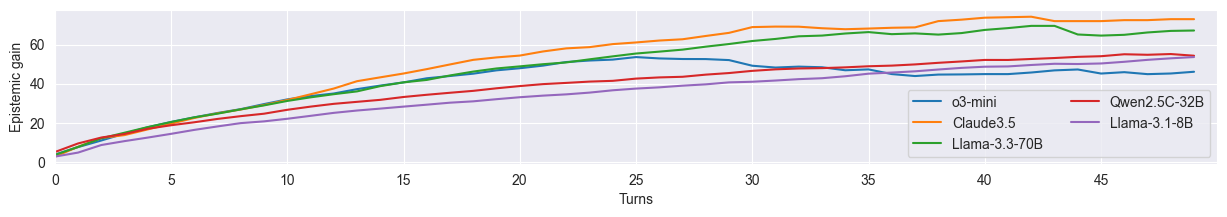

In [117]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Epistemic gain"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

plot_tag = "cumulative_epistemic_gain"
fig.savefig(f"results/{plot_tag}.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/{plot_tag}.png")

plt.show()

#### Paired epistemic gain and known goal entities plots

In [118]:
# plart =

known_goal_entities_ratio not in turn 1 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_15
known_goal_entities_ratio not in turn 21 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_8
known_goal_entities_ratio not in turn 25 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_12
known_goal_entities_ratio not in turn 22 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_14
known_goal_entities_ratio not in turn 41 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_2
known_goal_entities_ratio not in turn 46 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_10
known_goal_entities_ratio not in turn

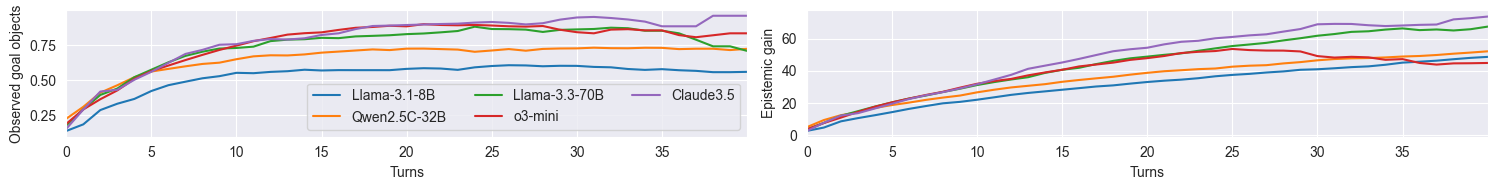

In [119]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))



metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 1 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_15
known_goal_entities_ratio not in turn 21 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_8
known_goal_entities_ratio not in turn 25 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_12
known_goal_entities_ratio not in turn 22 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 1_home_deliver_three_planning_easy episode_14
known_goal_entities_ratio not in turn 41 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_2
known_goal_entities_ratio not in turn 46 of Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0 7_home_deliver_three_planning_hard_invlimittwo episode_10
known_goal_entities_ratio not in turn

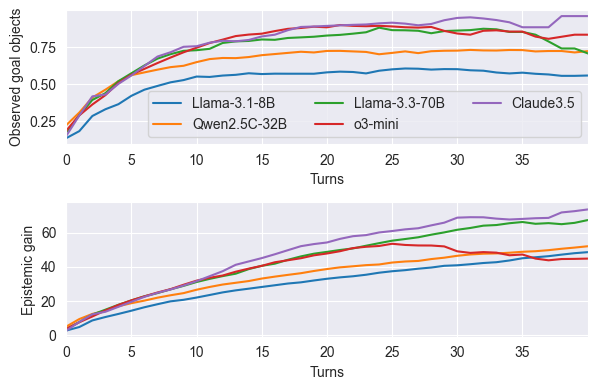

In [120]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))


metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired_vertical.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

#### Compound measures

In [121]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

avg_ep_acts = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")
avg_ep_gain = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "effective_epistemic_gain_amount")

epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
epistemic_action not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
epistemic_action not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.

In [122]:
def get_epistemic_effect(model_id: str, variants: list):
    avg_ep_acts = get_avg_turns_score(model_id, variants, "epistemic_action")
    avg_ep_gain = get_avg_turns_score(model_id, variants, "effective_epistemic_gain_amount")

    ep_effect_compound = avg_ep_acts * avg_ep_gain

    return ep_effect_compound

In [123]:
def get_epistemic_effect_progress_list(model_id: str, variant: str, episode: str):
    ep_acts = get_score_progress_list(model_id, variant, episode, "epistemic_action")
    print(ep_acts)
    ep_gain = get_score_progress_list(model_id, variant, episode, "effective_epistemic_gain_amount")
    print(ep_gain)

    epistemic_effect_progression = ep_acts * ep_gain

    return epistemic_effect_progression

In [124]:
# get_epistemic_effect_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "0_home_deliver_three_basic_easy", "episode_0")

In [125]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_9
epistemic_action not in turn 25 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_15
epistemic_action not in turn 12 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 2_home_deliver_three_basic_easy_invlimittwo episode_7
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_1
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_3
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 3_home_deliver_three_planning_easy_invlimittwo episode_5
epistemic_action not in turn 1 of o3-mini-2025-01-31-t0.

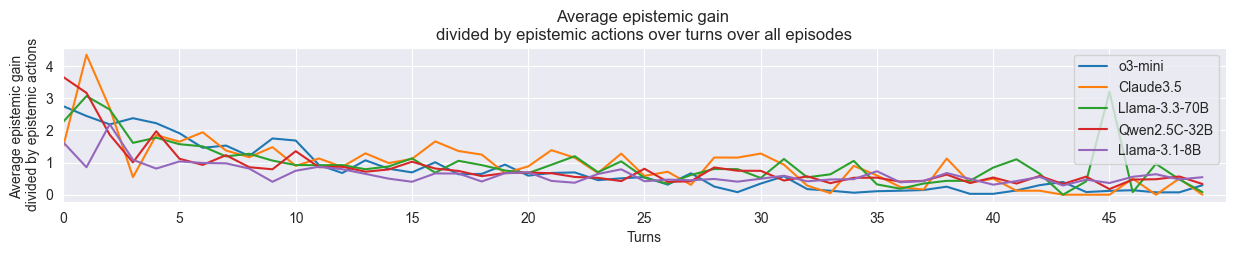

In [126]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_epistemic_effect("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants), label="o3-mini")
ax.plot(get_epistemic_effect("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants), label="Claude3.5")
ax.plot(get_epistemic_effect("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants), label="Llama-3.3-70B")
ax.plot(get_epistemic_effect("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants), label="Qwen2.5C-32B")
ax.plot(get_epistemic_effect("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants), label="Llama-3.1-8B")

metric_name = "epistemic gain \ndivided by epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_compound"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

### old

In [127]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

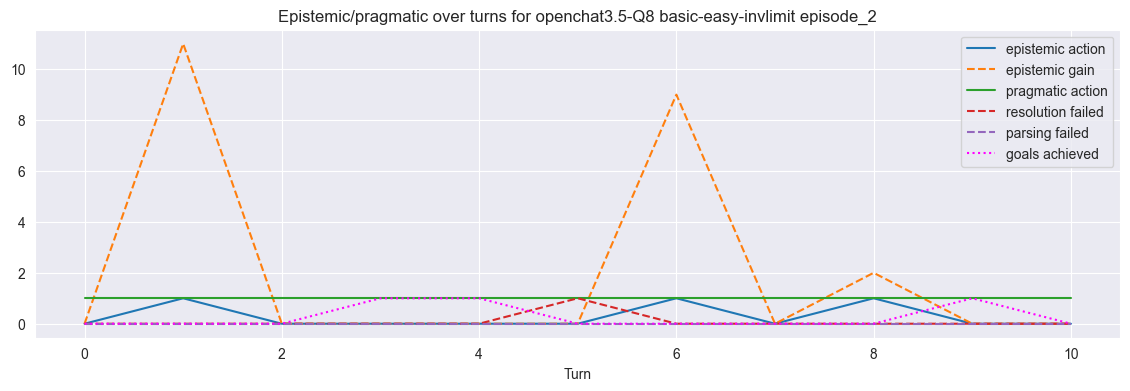

In [128]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [129]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [130]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [131]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")

In [132]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[6, 50, 11, 50, 6, 17, 15, 50, 22, 50, 10, 20, 50, 50, 15, 20]

In [133]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[1, 14, 3, 13, 1, 8, 6, 30, 4, 21, 3, 7, 29, 12, 6, 7]

In [134]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

np.float64(27.625)

In [135]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

np.float64(10.3125)

In [136]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [137]:
get_average_score_over_experiments(model_id, "epistemic_action")

([np.float64(30.875),
  np.float64(31.875),
  np.float64(27.625),
  np.float64(36.75),
  np.float64(38.25),
  np.float64(34.3125),
  np.float64(40.3125),
  np.float64(39.125)],
 [np.float64(10.625),
  np.float64(12.9375),
  np.float64(10.3125),
  np.float64(14.75),
  np.float64(20.5625),
  np.float64(20.25),
  np.float64(19.6875),
  np.float64(17.8125)])

In [138]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([np.float64(15.125),
  np.float64(16.125),
  np.float64(18.3125),
  np.float64(17.3125),
  np.float64(29.125),
  np.float64(31.25),
  np.float64(32.0625),
  np.float64(29.8125)],
 [np.float64(8.0),
  np.float64(8.5625),
  np.float64(9.625),
  np.float64(8.25),
  np.float64(19.625),
  np.float64(22.1875),
  np.float64(20.8125),
  np.float64(19.3125)])

In [139]:
# get averages for all models
def get_average_epistemic_all(model_names = None):
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()

    if not model_names:
        model_names = model_name_dict.keys()

    for model_id in model_names:
        print(model_id)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [140]:
avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all(top_models)
print(avg_turns_list)
print(avg_epistemic_gain_list)
print(avg_epistemic_actions_list)
print(avg_plan_viability_list)

o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0
claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0
gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0
Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0
Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0
[np.float64(23.0078125), np.float64(19.6484375), np.float64(24.171875), np.float64(23.2421875), np.float64(34.578125)]
[np.float64(45.0), np.float64(45.15625), np.float64(43.03125), np.float64(45.6953125), np.float64(49.0546875)]
[np.float64(13.3984375), np.float64(11.7890625), np.float64(14.8359375), np.float64(14.1015625), np.float64(22.5703125)]
[np.float64(1.707009548611111), np.float64(1.0041666666666667), np.float64(2.0682576321248196), np.float64(3.175799851190476), np.float64(2.5819847470238093)]


# Misc episode detection

## Good planning

In [141]:
get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")

known_entities_ratio not in turn 1 of o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0 1_home_deliver_three_planning_easy episode_3


array([0.0687004 , 0.07052951, 0.11301998, 0.15367406, 0.14420498,
       0.17010126, 0.18791735, 0.15876437, 0.15720551, 0.14940476,
       0.18484848, 0.24338624, 0.22592593, 0.24166667, 0.22038095,
       0.234375  , 0.18115942, 0.13518519, 0.14268293, 0.18947368,
       0.14380952, 0.11764706, 0.0862069 , 0.08333333, 0.03333333,
       0.04924242, 0.17063492, 0.14285714, 0.14166667, 0.08854167,
       0.17948718, 0.22222222, 0.08333333, 0.13636364, 0.225     ,
       0.02      , 0.03571429, 0.03571429, 0.05952381, 0.04761905,
       0.07142857, 0.05555556, 0.05555556, 0.        , 0.11111111,
       0.05555556, 0.05555556, 0.05      , 0.        , 0.        ])

In [142]:
def get_turn_score_progressions(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    # list_of_arrays = list()
    progs_dict = dict()
    for variant in variants:
        progs_dict[variant] = dict()
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            # list_of_arrays.append(prog_array)
            progs_dict[variant][episode] = prog_array
    # progress_array = np.array(list_of_arrays)
    # averages_array = np.nanmean(progress_array, axis=0)

    return progs_dict

In [143]:
variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo", "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]
# variants = ["3_home_deliver_three_planning_easy_invlimittwo"]

o3_plan_progs = get_turn_score_progressions("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "plan_command_success_ratio")
o3_plan_progs

{'1_home_deliver_three_planning_easy': {'episode_0': array([0.22222222, 0.125     , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.5       , 1.        , 1.        , 0.        ,
         1.        , 0.5       , 0.5       , 0.        , 0.        ,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan]),
  'episode_1': array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 1. , 0.5, 1. , 0. , 0. , nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan

In [144]:
def detect_best_earliest_score(prog_dict: dict, turn_offset_factor: float = 0.1):
    best_eps = list()
    best_score = 0
    best_earliest_eps = list()
    best_earliest_score = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score > best_score:
                    best_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_eps.append(best_ep)
                    best_score = turn_score

                turn_lateness_offset = turn_idx * turn_offset_factor
                turn_offset_score = turn_score - turn_lateness_offset
                if turn_offset_score > best_earliest_score:
                    best_earliest_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_earliest_eps.append(best_earliest_ep)
                    best_earliest_score = turn_offset_score

    return best_eps, best_earliest_eps

In [145]:
detect_best_earliest_score(o3_plan_progs, turn_offset_factor=0.01)

(['1_home_deliver_three_planning_easy episode_0 turn 0',
  '1_home_deliver_three_planning_easy episode_0 turn 11',
  '1_home_deliver_three_planning_easy episode_0 turn 12'],
 ['1_home_deliver_three_planning_easy episode_0 turn 0',
  '1_home_deliver_three_planning_easy episode_0 turn 11',
  '1_home_deliver_three_planning_easy episode_0 turn 12',
  '1_home_deliver_three_planning_easy episode_2 turn 9',
  '1_home_deliver_three_planning_easy episode_14 turn 0'])

In [146]:
def detect_best_long_plan(prog_dict: dict, model_id: str):
    best_longest_eps = list()
    best_score = 0
    longest_plan = 0
    highest_go = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            # for turn_idx, turn_acts in enumerate(ep_interactions['turns']):

            ep_plan_lengths = list()
            ep_plan_go_count = list()

            for turn_acts in ep_interactions['turns']:
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'plan_length':
                        ep_plan_lengths.append(turn_act['action']['content'])
                    if turn_act['action']['type'] == 'current_plan':
                        go_count = 0
                        split_plan = turn_act['action']['content'][1:-1].replace("'", "").split(", ")
                        # for planned_action in turn_act['action']['content']:
                        for planned_action in split_plan:
                            # print(planned_action)
                            # "go" | "enter" | "return" | "proceed" | "move\
                            if planned_action.startswith(('go', 'move', 'enter', 'return', 'proceed')):
                                go_count += 1
                        ep_plan_go_count.append(go_count)

            # print(variant, ep_id, ep_plan_go_count)

            # print(ep_plan_lengths)

            for turn_idx in range(50):
                long = False
                more_go = False
                if turn_idx < len(ep_plan_lengths):
                    turn_score = progression[turn_idx]
                    if ep_plan_lengths[turn_idx] >= longest_plan:
                        long = True
                        longest_plan = ep_plan_lengths[turn_idx]

                    if ep_plan_go_count[turn_idx] > highest_go:
                        more_go = True
                        highest_go = ep_plan_go_count[turn_idx]

                    plan_turn_score = ep_plan_lengths[turn_idx] * turn_score

                    # if long and more_go and turn_score > best_score:
                    if plan_turn_score > best_score:
                        # if long and plan_turn_score > best_score:
                        best_ep = f"{variant} {ep_id} turn {turn_idx}"
                        best_longest_eps.append(best_ep)
                        # best_score = turn_score
                        best_score = plan_turn_score

    print(best_score, longest_plan)

    return best_longest_eps

In [147]:
detect_best_long_plan(o3_plan_progs, "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0")

9.0 12


['1_home_deliver_three_planning_easy episode_0 turn 0',
 '1_home_deliver_three_planning_easy episode_0 turn 11',
 '1_home_deliver_three_planning_easy episode_0 turn 12',
 '1_home_deliver_three_planning_easy episode_14 turn 0',
 '3_home_deliver_three_planning_easy_invlimittwo episode_10 turn 6']

## Navigation

In [148]:
variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

claude_nav_progs = get_turn_score_progressions('claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0', variants, "no_exit_to")

In [149]:
def detect_nav_fail_correction(prog_dict: dict, model_id: str):
    corrected_eps = list()
    bad_eps = list()
    double_nav_fails = list()
    prime_examples = list()
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            single_fail = False
            single_fail_turn = int()

            nav_fail_sum = np.nansum(progression)
            if not 2 > nav_fail_sum > 0:
                single_fail = True

            if nav_fail_sum > 5:
                bad_eps.append(f"{variant} {ep_id}")

            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score == 1:
                    # check if next turn is a nav fail too
                    if turn_idx+1 < 50 and progression[turn_idx+1] == 1:
                        double_nav_fails.append(f"{variant} {ep_id}")
                    if single_fail:
                        single_fail_turn = turn_idx

            if not single_fail:
                continue

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            correct_go_turns = list()

            for turn_idx, turn_acts in enumerate(ep_interactions['turns']):
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'action_info':
                        act_content = turn_act['action']['content']
                        if act_content['action_type'] == "go":
                            correct_go_turns.append(turn_idx)

            for later_turn in range(single_fail_turn, len(ep_interactions['turns'])):
                cur_ep = f"{variant} {ep_id}"
                if later_turn in correct_go_turns and cur_ep not in corrected_eps:
                    corrected_eps.append(f"{variant} {ep_id}")

            if single_fail_turn+1 in correct_go_turns and single_fail_turn+2 in correct_go_turns and single_fail_turn+3 in correct_go_turns:
                prime_examples.append(f"{variant} {ep_id} turn {single_fail_turn}")



    return {'corrected': corrected_eps, 'bad': bad_eps, 'double_fails': double_nav_fails, 'prime_examples': prime_examples}

In [150]:
detect_nav_fail_correction(claude_nav_progs, 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0')

{'corrected': ['0_home_deliver_three_basic_easy episode_0',
  '0_home_deliver_three_basic_easy episode_1',
  '0_home_deliver_three_basic_easy episode_2',
  '0_home_deliver_three_basic_easy episode_4',
  '0_home_deliver_three_basic_easy episode_5',
  '0_home_deliver_three_basic_easy episode_7',
  '0_home_deliver_three_basic_easy episode_8',
  '0_home_deliver_three_basic_easy episode_9',
  '0_home_deliver_three_basic_easy episode_10',
  '0_home_deliver_three_basic_easy episode_12',
  '0_home_deliver_three_basic_easy episode_13',
  '0_home_deliver_three_basic_easy episode_14',
  '0_home_deliver_three_basic_easy episode_15',
  '1_home_deliver_three_planning_easy episode_0',
  '1_home_deliver_three_planning_easy episode_1',
  '1_home_deliver_three_planning_easy episode_2',
  '1_home_deliver_three_planning_easy episode_3',
  '1_home_deliver_three_planning_easy episode_4',
  '1_home_deliver_three_planning_easy episode_5',
  '1_home_deliver_three_planning_easy episode_6',
  '1_home_deliver_thr